In [ ]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional (for correlation p-values)
try:
    from scipy.stats import pearsonr, spearmanr
except Exception:
    pearsonr, spearmanr = None, None

# -----------------------------
# Global plotting style (Nature-ish, minimal, readable)
# -----------------------------
plt.rcParams["figure.dpi"] = 160
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["font.size"] = 9
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["axes.labelsize"] = 9
plt.rcParams["legend.fontsize"] = 8
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.25
plt.rcParams["legend.frameon"] = False

FIG_DIR = os.path.join("..", "results", "figs")
os.makedirs(FIG_DIR, exist_ok=True)

def _first_existing_path(paths):
    for p in paths:
        if p is None:
            continue
        if os.path.exists(p):
            return p
    return None

def load_exp14_summary():
    # Try common locations (repo-style + local upload-style).
    candidates = [
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary.csv"),
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary_v2.csv"),
        os.path.join("..", "results", "tables", "exp14_multicity_tabular_summary_v3.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary_v2.csv"),
        os.path.join("results", "tables", "exp14_multicity_tabular_summary_v3.csv"),
        os.path.join(".", "exp14_multicity_tabular_summary.csv"),
        os.path.join(".", "exp14_multicity_tabular_summary_v2.csv"),
        "/mnt/data/exp14_multicity_tabular_summary.csv",
    ]
    path = _first_existing_path(candidates)
    if path is None:
        raise FileNotFoundError(
            "Could not find exp14 summary CSV. "
            "Please place it under ../results/tables/exp14_multicity_tabular_summary.csv "
            "or set CSV_PATH manually."
        )

    print(f"[OK] Loading Exp14 summary from: {path}")
    df = pd.read_csv(path)
    return df

df = load_exp14_summary()
print("Rows:", len(df), "| Cols:", len(df.columns))
df.head(3)


In [ ]:

# -----------------------------
# Basic cleaning and sanity checks
# -----------------------------
required_cols = [
    "City", "PIER",
    "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Coerce key numeric columns
numeric_cols = [
    "PIER", "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
    "PairwiseMeanAbsDiff", "ClosestPeerMeanAbsDiff",
    "WeightEntropy", "WeightEntropyNorm", "EffectivePeers_HHI",
    "FitDistance",
]
for c in numeric_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

df["City"] = df["City"].astype(str)

# Drop rows with missing essential values
before = len(df)
df = df.dropna(subset=["City", "PIER", "Delta_Global", "Delta_Router"]).copy()
after = len(df)
print(f"Dropped {before-after} rows with missing essentials. Remaining: {after}")

# Quick look at potential extreme values
print("Top-5 by PIER:")
display(df.sort_values("PIER", ascending=False)[["City", "PIER", "Delta_Global", "Delta_Router", "Local_MAE", "Router_MAE", "Global_MAE"]].head(5))

print("\nBottom-5 by PIER:")
display(df.sort_values("PIER", ascending=True)[["City", "PIER", "Delta_Global", "Delta_Router", "Local_MAE", "Router_MAE", "Global_MAE"]].head(5))


In [ ]:

# -----------------------------
# Outlier detection helpers (robust + transparent)
# -----------------------------
def mad_based_zscore(x: np.ndarray, eps: float = 1e-12):
    x = np.asarray(x, dtype=float)
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad < eps:
        return np.zeros_like(x)
    return 0.6745 * (x - med) / mad

def iqr_bounds(x: np.ndarray, k: float = 1.5):
    x = np.asarray(x, dtype=float)
    q1 = np.nanpercentile(x, 25)
    q3 = np.nanpercentile(x, 75)
    iqr = q3 - q1
    lo = q1 - k * iqr
    hi = q3 + k * iqr
    return lo, hi, q1, q3, iqr

def flag_outliers(df_in: pd.DataFrame, col: str, method: str = "iqr", **kwargs):
    df_in = df_in.copy()
    x = df_in[col].to_numpy(dtype=float)
    if method == "iqr":
        lo, hi, q1, q3, iqr = iqr_bounds(x, k=float(kwargs.get("k", 1.5)))
        df_in["_is_outlier"] = (x < lo) | (x > hi)
        meta = dict(method="iqr", lo=lo, hi=hi, q1=q1, q3=q3, iqr=iqr)
        return df_in, meta
    elif method == "mad":
        z = mad_based_zscore(x)
        thr = float(kwargs.get("thr", 3.5))
        df_in["_is_outlier"] = np.abs(z) > thr
        meta = dict(method="mad", thr=thr)
        return df_in, meta
    else:
        raise ValueError("method must be 'iqr' or 'mad'")

# Flag outliers by PIER (two common robust choices)
df_iqr, meta_iqr = flag_outliers(df, col="PIER", method="iqr", k=1.5)
df_mad, meta_mad = flag_outliers(df, col="PIER", method="mad", thr=3.5)

outliers_iqr = df_iqr[df_iqr["_is_outlier"]].sort_values("PIER", ascending=False)
outliers_mad = df_mad[df_mad["_is_outlier"]].sort_values("PIER", ascending=False)

print("IQR outlier rule on PIER:", meta_iqr)
print("MAD outlier rule on PIER:", meta_mad)

print("\nOutliers by IQR (PIER):")
display(outliers_iqr[["City", "PIER", "Delta_Global", "Delta_Router"]])

print("\nOutliers by MAD (PIER):")
display(outliers_mad[["City", "PIER", "Delta_Global", "Delta_Router"]])

# Manual list (common in rebuttals: show 'with' and 'without' a known outlier)
MANUAL_EXCLUDE = ["paris"]
print("\nManual exclude list:", MANUAL_EXCLUDE)


In [ ]:

# -----------------------------
# Correlation helpers
# -----------------------------
def corr_pair(x: np.ndarray, y: np.ndarray):
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]
    if x.size < 3:
        return dict(n=int(x.size), pearson=np.nan, pearson_p=np.nan, spearman=np.nan, spearman_p=np.nan)

    if pearsonr is not None:
        pr, pp = pearsonr(x, y)
    else:
        pr = np.corrcoef(x, y)[0, 1]
        pp = np.nan

    if spearmanr is not None:
        sr, sp = spearmanr(x, y)
    else:
        # Fall back to Pearson correlation of ranks
        xr = pd.Series(x).rank().to_numpy()
        yr = pd.Series(y).rank().to_numpy()
        sr = np.corrcoef(xr, yr)[0, 1]
        sp = np.nan

    return dict(n=int(x.size), pearson=float(pr), pearson_p=float(pp), spearman=float(sr), spearman_p=float(sp))

def print_corr(df_in: pd.DataFrame, xcol: str, ycol: str, label: str):
    stats = corr_pair(df_in[xcol].to_numpy(), df_in[ycol].to_numpy())
    print(f"[{label}] n={stats['n']} | Pearson r={stats['pearson']:.3f} (p={stats['pearson_p']:.2e}) | "
          f"Spearman ρ={stats['spearman']:.3f} (p={stats['spearman_p']:.2e})")

def add_health_flags(df_in: pd.DataFrame) -> pd.DataFrame:
    df2 = df_in.copy()
    df2["Healthy"] = (df2["Delta_Global"] >= 0.0) & (df2["Delta_Router"] >= 0.0)
    df2["Unhealthy"] = ~df2["Healthy"]
    return df2

df0 = add_health_flags(df)

# Correlations on the full set
print_corr(df0, "PIER", "Delta_Router", "All: PIER vs ΔRouter")
print_corr(df0, "PIER", "Delta_Global", "All: PIER vs ΔGlobal")

# Exclude manual outliers
df_no_manual = df0[~df0["City"].isin(MANUAL_EXCLUDE)].copy()
print_corr(df_no_manual, "PIER", "Delta_Router", "No-manual-outliers: PIER vs ΔRouter")
print_corr(df_no_manual, "PIER", "Delta_Global", "No-manual-outliers: PIER vs ΔGlobal")

# Exclude IQR outliers
df_no_iqr = add_health_flags(df_iqr[~df_iqr["_is_outlier"]].drop(columns=["_is_outlier"]))
print_corr(df_no_iqr, "PIER", "Delta_Router", "No-IQR-outliers: PIER vs ΔRouter")
print_corr(df_no_iqr, "PIER", "Delta_Global", "No-IQR-outliers: PIER vs ΔGlobal")

# Also look at the healthy subset only (arguably the cleanest 'replacement-cost' regime)
print_corr(df_no_iqr[df_no_iqr["Healthy"]], "PIER", "Delta_Router", "Healthy & No-IQR-outliers: PIER vs ΔRouter")
print_corr(df_no_iqr[df_no_iqr["Healthy"]], "PIER", "Delta_Global", "Healthy & No-IQR-outliers: PIER vs ΔGlobal")


In [ ]:

# -----------------------------
# Plot 1: PIER distribution + highlight outliers
# -----------------------------
def plot_pier_distribution(df_in: pd.DataFrame, title: str, save_name: str = None):
    x = df_in["PIER"].to_numpy(dtype=float)
    x = x[np.isfinite(x)]

    fig = plt.figure(figsize=(7.6, 2.6))
    ax1 = plt.subplot(1, 2, 1)
    ax1.hist(x, bins=14)
    ax1.set_title(title)
    ax1.set_xlabel("PIER")
    ax1.set_ylabel("Count")

    ax2 = plt.subplot(1, 2, 2)
    ax2.boxplot(x, vert=True, showfliers=True)
    ax2.set_title("Box plot (with fliers)")
    ax2.set_ylabel("PIER")
    ax2.set_xticks([1])
    ax2.set_xticklabels([""])

    plt.tight_layout()

    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)

    plt.show()

plot_pier_distribution(df0, "Exp14: PIER distribution (all cities)", save_name="exp14_pier_distribution_all.png")
plot_pier_distribution(df_no_iqr, "Exp14: PIER distribution (IQR outliers removed)", save_name="exp14_pier_distribution_no_iqr.png")


In [ ]:

# -----------------------------
# Plot 2: Scatter PIER vs ΔRouter (with outliers marked)
# -----------------------------
def scatter_pier_vs_delta(df_all: pd.DataFrame, df_clean: pd.DataFrame, label_clean: str, save_name: str = None):
    fig = plt.figure(figsize=(7.6, 3.0))

    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(df_all["Delta_Router"], df_all["PIER"], s=35)
    for _, r in df_all[df_all["City"].isin(MANUAL_EXCLUDE)].iterrows():
        ax1.scatter([r["Delta_Router"]], [r["PIER"]], s=70, marker="X")
        ax1.text(r["Delta_Router"], r["PIER"], str(r["City"]), fontsize=8, ha="left", va="bottom")
    ax1.axvline(0.0, linewidth=0.8, linestyle="--")
    ax1.set_xlabel("ΔRouter = MAE(router) − MAE(local)")
    ax1.set_ylabel("PIER")
    ax1.set_title("All cities (manual outlier marked)")

    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(df_clean["Delta_Router"], df_clean["PIER"], s=35)
    ax2.axvline(0.0, linewidth=0.8, linestyle="--")
    ax2.set_xlabel("ΔRouter")
    ax2.set_ylabel("PIER")
    ax2.set_title(label_clean)

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

scatter_pier_vs_delta(df0, df_no_iqr, "IQR outliers removed", save_name="exp14_scatter_pier_vs_delta_router.png")


In [ ]:

# -----------------------------
# Plot 3: Quadrant plot (ΔGlobal vs ΔRouter) with point size ~ PIER
# -----------------------------
def quadrant_plot(df_in: pd.DataFrame, title: str, save_name: str = None):
    dfp = df_in.copy()
    # Size scaling (robust): clip at 95th percentile to avoid one point dominating
    s_raw = dfp["PIER"].to_numpy(dtype=float)
    s_clip = np.nanpercentile(s_raw, 95)
    s = np.clip(s_raw, 0.0, s_clip)
    s = 25.0 + 175.0 * (s / (s_clip + 1e-12))

    fig = plt.figure(figsize=(4.1, 3.4))
    ax = plt.gca()
    ax.scatter(dfp["Delta_Global"], dfp["Delta_Router"], s=s, alpha=0.85)

    ax.axhline(0.0, linewidth=0.8, linestyle="--")
    ax.axvline(0.0, linewidth=0.8, linestyle="--")

    ax.set_xlabel("ΔGlobal = MAE(global) − MAE(local)")
    ax.set_ylabel("ΔRouter = MAE(router) − MAE(local)")
    ax.set_title(title)

    # Annotate a few extremes (largest PIER after filtering)
    top = dfp.sort_values("PIER", ascending=False).head(6)
    for _, r in top.iterrows():
        ax.text(r["Delta_Global"], r["Delta_Router"], str(r["City"]), fontsize=7, ha="left", va="bottom")

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

quadrant_plot(df0, "All cities: ΔGlobal vs ΔRouter (size ∝ PIER)", save_name="exp14_quadrant_all.png")
quadrant_plot(df_no_iqr, "IQR outliers removed: ΔGlobal vs ΔRouter (size ∝ PIER)", save_name="exp14_quadrant_no_iqr.png")


In [ ]:

# -----------------------------
# Evidence chain checks (after outlier removal):
# 1) PIER aligns with internal "approximation hardness" (FitDistance, PairwiseMeanAbsDiff)
# 2) PIER relates to how concentrated the convex fit is (entropy / effective peers)
# -----------------------------
def scatter_with_fit(df_in: pd.DataFrame, xcol: str, ycol: str, title: str, xlabel: str, ylabel: str, save_name: str = None):
    x = df_in[xcol].to_numpy(dtype=float)
    y = df_in[ycol].to_numpy(dtype=float)
    mask = np.isfinite(x) & np.isfinite(y)
    x = x[mask]
    y = y[mask]

    fig = plt.figure(figsize=(4.1, 3.4))
    ax = plt.gca()
    ax.scatter(x, y, s=35, alpha=0.85)

    # Linear fit (least squares) for visualization only
    if x.size >= 3:
        a, b = np.polyfit(x, y, deg=1)
        xx = np.linspace(np.min(x), np.max(x), 100)
        yy = a * xx + b
        ax.plot(xx, yy, linewidth=1.5)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # Correlation report (robust: Pearson + Spearman)
    stats = corr_pair(x, y)
    ax.text(
        0.02, 0.98,
        f"n={stats['n']}\nPearson r={stats['pearson']:.2f}\nSpearman ρ={stats['spearman']:.2f}",
        transform=ax.transAxes,
        ha="left", va="top", fontsize=8
    )

    plt.tight_layout()
    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)
    plt.show()

df_clean = df_no_iqr.copy()

if "FitDistance" in df_clean.columns:
    scatter_with_fit(
        df_clean, "FitDistance", "PIER",
        title="PIER vs DISCO fit distance (outliers removed)",
        xlabel="DISCO fit distance (on P_fit)",
        ylabel="PIER (on P_eval)",
        save_name="exp14_pier_vs_fitdistance.png",
    )

if "PairwiseMeanAbsDiff" in df_clean.columns:
    scatter_with_fit(
        df_clean, "PairwiseMeanAbsDiff", "PIER",
        title="PIER vs mean pairwise model differencing (outliers removed)",
        xlabel="Mean |ŷ_i − ŷ_j| over peers",
        ylabel="PIER",
        save_name="exp14_pier_vs_pairwise_mean_abs_diff.png",
    )

if "WeightEntropyNorm" in df_clean.columns:
    scatter_with_fit(
        df_clean, "WeightEntropyNorm", "PIER",
        title="PIER vs normalized weight entropy (outliers removed)",
        xlabel="Normalized entropy of DISCO weights",
        ylabel="PIER",
        save_name="exp14_pier_vs_entropy_norm.png",
    )

if "EffectivePeers_HHI" in df_clean.columns:
    scatter_with_fit(
        df_clean, "EffectivePeers_HHI", "PIER",
        title="PIER vs effective peers (HHI) (outliers removed)",
        xlabel="Effective peers (1 / ∑ w_k^2)",
        ylabel="PIER",
        save_name="exp14_pier_vs_effective_peers.png",
    )


In [ ]:

# -----------------------------
# Summary tables for writing the paper (after outlier removal)
# -----------------------------
df_clean = df_no_iqr.copy()

# Define a few interpretable "types" (paper-friendly):
# - Healthy unique:     ΔGlobal>0 and ΔRouter>0 and high PIER
# - Healthy redundant:  ΔGlobal>0 and ΔRouter>0 and low PIER
# - Unhealthy unique:   (ΔGlobal<0 or ΔRouter<0) and high PIER
# - Unhealthy redundant:(ΔGlobal<0 or ΔRouter<0) and low PIER
#
# Thresholds are robust quantiles (not arbitrary constants).
pier_hi = float(df_clean["PIER"].quantile(0.75))
pier_lo = float(df_clean["PIER"].quantile(0.25))

df_clean["Type"] = "Other"
df_clean.loc[df_clean["Healthy"] & (df_clean["PIER"] >= pier_hi), "Type"] = "Healthy-Unique"
df_clean.loc[df_clean["Healthy"] & (df_clean["PIER"] <= pier_lo), "Type"] = "Healthy-Redundant"
df_clean.loc[df_clean["Unhealthy"] & (df_clean["PIER"] >= pier_hi), "Type"] = "Unhealthy-Unique"
df_clean.loc[df_clean["Unhealthy"] & (df_clean["PIER"] <= pier_lo), "Type"] = "Unhealthy-Redundant"

print("PIER quantiles (clean): Q25=%.3f, Q75=%.3f" % (pier_lo, pier_hi))
print("\nCounts by Type:")
display(df_clean["Type"].value_counts().to_frame("count"))

cols_show = [
    "City", "Type", "PIER",
    "Local_MAE", "Global_MAE", "Router_MAE",
    "Delta_Global", "Delta_Router",
    "Local_MAE_Ratio", "Skill_vs_Persist",
    "ClosestPeerName", "ClosestPeerMeanAbsDiff",
    "WeightEntropyNorm", "EffectivePeers_HHI",
]

cols_show = [c for c in cols_show if c in df_clean.columns]

print("\nTop-10 PIER cities (clean):")
display(df_clean.sort_values("PIER", ascending=False)[cols_show].head(10))

print("\nBottom-10 PIER cities (clean):")
display(df_clean.sort_values("PIER", ascending=True)[cols_show].head(10))

print("\nHealthy-Unique examples:")
display(df_clean[df_clean["Type"] == "Healthy-Unique"].sort_values("PIER", ascending=False)[cols_show].head(8))

print("\nUnhealthy-Unique examples:")
display(df_clean[df_clean["Type"] == "Unhealthy-Unique"].sort_values("PIER", ascending=False)[cols_show].head(8))


In [ ]:

# -----------------------------
# Sanity: show how conclusions change when removing *only* Paris vs robust outlier removal
# -----------------------------
def summary_stats(df_in: pd.DataFrame, label: str):
    stats = {
        "n": len(df_in),
        "PIER_mean": float(df_in["PIER"].mean()),
        "PIER_median": float(df_in["PIER"].median()),
        "PIER_p90": float(df_in["PIER"].quantile(0.90)),
        "DeltaRouter_mean": float(df_in["Delta_Router"].mean()),
        "DeltaGlobal_mean": float(df_in["Delta_Global"].mean()),
        "Healthy_frac": float(((df_in["Delta_Router"] >= 0) & (df_in["Delta_Global"] >= 0)).mean()),
    }
    print(f"\n[{label}]")
    for k, v in stats.items():
        if k == "n":
            print(f"  {k:>14s}: {int(v)}")
        else:
            print(f"  {k:>14s}: {v: .4f}")

summary_stats(df0, "All cities")
summary_stats(df_no_manual, "Manual exclude (paris) only")
summary_stats(df_no_iqr, "IQR outliers removed")

print_corr(df0, "PIER", "Delta_Router", "All: PIER vs ΔRouter")
print_corr(df_no_manual, "PIER", "Delta_Router", "No-paris: PIER vs ΔRouter")
print_corr(df_no_iqr, "PIER", "Delta_Router", "No-IQR-outliers: PIER vs ΔRouter")

print_corr(df0, "PIER", "Delta_Global", "All: PIER vs ΔGlobal")
print_corr(df_no_manual, "PIER", "Delta_Global", "No-paris: PIER vs ΔGlobal")
print_corr(df_no_iqr, "PIER", "Delta_Global", "No-IQR-outliers: PIER vs ΔGlobal")


In [ ]:
# -----------------------------
# Quadrant plot: PIER vs ΔRouter
# -----------------------------
def plot_quadrant_pier_delta_router(df_in: pd.DataFrame, title: str, pier_thr: float = None, save_name: str = None):
    """
    Quadrant view in (PIER, ΔRouter):
      - x-axis: PIER
      - y-axis: ΔRouter
    Thresholds:
      - vertical line: PIER median (or provided pier_thr)
      - horizontal line: ΔRouter = 0
    """
    d = df_in.copy()

    if pier_thr is None:
        pier_thr = float(d["PIER"].median())

    fig = plt.figure(figsize=(4.6, 3.6))
    ax = plt.gca()

    q1 = d[(d["PIER"] >= pier_thr) & (d["Delta_Router"] >= 0.0)]
    q2 = d[(d["PIER"] <  pier_thr) & (d["Delta_Router"] >= 0.0)]
    q3 = d[(d["PIER"] >= pier_thr) & (d["Delta_Router"] <  0.0)]
    q4 = d[(d["PIER"] <  pier_thr) & (d["Delta_Router"] <  0.0)]

    # Use different markers only (avoid custom colors)
    ax.scatter(q1["PIER"], q1["Delta_Router"], s=30, alpha=0.9, label="High PIER, ΔRouter ≥ 0 (valuable uniqueness)")
    ax.scatter(q3["PIER"], q3["Delta_Router"], s=30, alpha=0.9, marker="s", label="High PIER, ΔRouter < 0 (harmful uniqueness)")
    ax.scatter(q2["PIER"], q2["Delta_Router"], s=30, alpha=0.75, marker="^", label="Low PIER, ΔRouter ≥ 0")
    ax.scatter(q4["PIER"], q4["Delta_Router"], s=30, alpha=0.75, marker="v", label="Low PIER, ΔRouter < 0")

    ax.axvline(pier_thr, linewidth=1.0, linestyle="--")
    ax.axhline(0.0, linewidth=1.0, linestyle="--")

    ax.set_xlabel("PIER")
    ax.set_ylabel("ΔRouter = MAE(router) − MAE(local)")
    ax.set_title(title)

    # Annotate a few informative cities
    to_anno = []
    to_anno += d.sort_values("PIER", ascending=False)["City"].head(4).tolist()
    to_anno += d.sort_values("Delta_Router", ascending=False)["City"].head(3).tolist()
    to_anno += d.sort_values("Delta_Router", ascending=True)["City"].head(3).tolist()
    to_anno = list(dict.fromkeys(to_anno))

    for city in to_anno:
        sub = d[d["City"] == city]
        if sub.empty:
            continue
        x = float(sub.iloc[0]["PIER"])
        y = float(sub.iloc[0]["Delta_Router"])
        ax.text(x, y, city, fontsize=7, ha="left", va="bottom")

    ax.legend(loc="best", fontsize=7)
    plt.tight_layout()

    if save_name is not None:
        out = os.path.join(FIG_DIR, save_name)
        plt.savefig(out, bbox_inches="tight")
        print("[Saved]", out)

    plt.show()


# All cities
plot_quadrant_pier_delta_router(
    df0,
    title="Quadrant: PIER vs ΔRouter (all cities)",
    pier_thr=float(df0["PIER"].median()),
    # pier_thr=float(df["PIER"].quantile(0.75)),
    save_name="exp14_quadrant_pier_vs_delta_router_all.png",
)

# IQR outliers removed (PIER-based)
plot_quadrant_pier_delta_router(
    df_no_iqr,
    title="Quadrant: PIER vs ΔRouter (IQR outliers removed)",
    pier_thr=float(df_no_iqr["PIER"].median()),
    # pier_thr=float(df["PIER"].quantile(0.75)),
    save_name="exp14_quadrant_pier_vs_delta_router_no_iqr.png",
)


Saved: ../results/figures/fig5A_multicity_pier_vs_cost.pdf


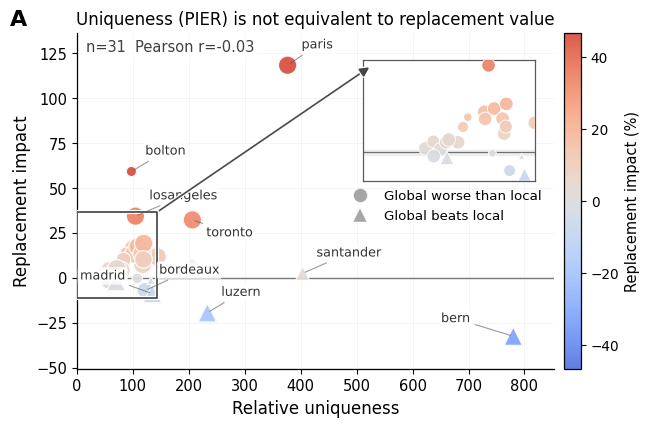

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib.patches import Rectangle, ConnectionPatch


# -------------------------
# Style helpers (reuse across Fig.5A–E)
# -------------------------
def apply_nature_style():
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.12,
        "grid.linewidth": 0.7,
        "legend.frameon": False,
    })


def truncate_cmap(cmap, minval=0.08, maxval=0.92, n=256):
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )


def add_panel_label(ax, label="A"):
    ax.text(-0.14, 1.01, label, transform=ax.transAxes,
            fontsize=16, fontweight="bold", va="bottom")


def annotate_offset(ax, xy, text, dx=6, dy=6, fontsize=9.2, color="0.20", **kwargs):
    return ax.annotate(
        text,
        xy=xy,
        xytext=(dx, dy),
        textcoords="offset points",
        ha=kwargs.pop("ha", "left"),
        va=kwargs.pop("va", "bottom"),
        fontsize=fontsize,
        color=color,
        **kwargs
    )


def smart_annotate_no_overlap(ax, xy, text, used_bboxes, candidates):
    """
    Place a label with offset-points; try multiple offsets to avoid overlap.
    """
    fig = ax.figure
    fig.canvas.draw()
    renderer = fig.canvas.get_renderer()

    ax_bbox = ax.get_window_extent(renderer=renderer).expanded(1.00, 1.00)

    for (dx, dy) in candidates:
        ann = annotate_offset(
            ax, xy, text, dx=dx, dy=dy,
            fontsize=9.2, color="0.20",
            path_effects=[pe.withStroke(linewidth=3, foreground="white")],
            bbox=dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.78),
            arrowprops=dict(arrowstyle="-", lw=0.8, color="0.35", alpha=0.6),
            zorder=10
        )
        fig.canvas.draw()
        bb = ann.get_window_extent(renderer=renderer).expanded(1.03, 1.12)

        inside = ax_bbox.contains(*bb.get_points()[0]) and ax_bbox.contains(*bb.get_points()[1])
        overlap = any(bb.overlaps(b) for b in used_bboxes)

        if inside and (not overlap):
            used_bboxes.append(bb)
            return ann

        ann.remove()

    # fallback
    dx, dy = candidates[0]
    ann = annotate_offset(
        ax, xy, text, dx=dx, dy=dy,
        fontsize=9.2, color="0.20",
        path_effects=[pe.withStroke(linewidth=3, foreground="white")],
        bbox=dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.78),
        arrowprops=dict(arrowstyle="-", lw=0.8, color="0.35", alpha=0.6),
        zorder=10
    )
    fig.canvas.draw()
    used_bboxes.append(ann.get_window_extent(renderer=renderer).expanded(1.03, 1.12))
    return ann


# -------------------------
# Fig.5A
# -------------------------
def plot_fig5A_multicity_pier_vs_cost(
    summary_csv: str = "../results/tables/exp14_multicity_tabular_summary.csv",
    save_path: str = None,
    no_change_band_pct: float = 1.0,
    annotate_top_k: int = 4,
):
    """
    Fig.5A: City-level scatter linking label-free uniqueness (PIER)
    to label-based substitution cost (Delta_Router).

    x: 1000 * PIER / MeanFlow_Test  (‰)
    y: 100 * Delta_Router / Local_MAE  (%)
    color: y (diverging centered at 0)
    marker: triangle if Delta_Global < 0 (global beats local), else circle
    size: NumTest (sqrt-scaled)
    """

    apply_nature_style()

    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Summary CSV not found: {summary_csv}")

    df = pd.read_csv(summary_csv)
    req = {"City", "PIER", "Delta_Router", "Delta_Global", "MeanFlow_Test", "Local_MAE", "NumTest"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

    d = df.copy()
    for c in ["PIER", "Delta_Router", "Delta_Global", "MeanFlow_Test", "Local_MAE", "NumTest"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=list(req)).copy()

    eps = 1e-12
    d["x_permil"] = 1000.0 * d["PIER"] / (d["MeanFlow_Test"].abs() + eps)
    d["y_pct"]    = 100.0  * d["Delta_Router"] / (d["Local_MAE"].abs() + eps)
    d["global_beats_local"] = d["Delta_Global"] < 0

    # size encoding (sqrt scaling)
    n = np.clip(d["NumTest"].to_numpy(dtype=float), 1.0, None)
    s = 34.0 + 140.0 * (np.sqrt(n) - np.sqrt(n.min())) / (np.sqrt(n.max()) - np.sqrt(n.min()) + 1e-12)
    d["size"] = s

    # diverging color (center 0)
    cmap = truncate_cmap(plt.get_cmap("coolwarm"), 0.10, 0.90)
    vmax = float(np.nanpercentile(np.abs(d["y_pct"]), 95))
    vmax = max(vmax, 5.0)
    norm = mcolors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    fig, ax = plt.subplots(figsize=(6.4, 4.8))

    # no-change band + boundaries (cleaner than large text)
    # ax.axhspan(-no_change_band_pct, no_change_band_pct, color="0.93", zorder=0)
    # ax.axhline(+no_change_band_pct, color="0.65", lw=0.9, ls="--", alpha=0.7, zorder=1)
    # ax.axhline(-no_change_band_pct, color="0.65", lw=0.9, ls="--", alpha=0.7, zorder=1)
    ax.axhline(0.0, color="0.35", lw=1.0, alpha=0.85, zorder=1)

    # plot groups
    sc_last = None
    for flag, marker in [(False, "o"), (True, "^")]:
        sub = d[d["global_beats_local"] == flag]
        sc = ax.scatter(
            sub["x_permil"], sub["y_pct"],
            s=sub["size"],
            c=sub["y_pct"], cmap=cmap, norm=norm,
            marker=marker,
            edgecolor="white",
            linewidth=0.85,
            alpha=0.95,
            zorder=3
        )
        # subtle dark halo to keep visibility on pale colors
        ax.scatter(
            sub["x_permil"], sub["y_pct"],
            s=sub["size"],
            facecolors="none",
            edgecolors="0.15",
            linewidth=0.45,
            marker=marker,
            alpha=0.28,
            zorder=2
        )
        sc_last = sc

    ax.set_xlabel(r"Relative uniqueness") # $1000 \times \mathrm{PIER}/\overline{\mathrm{flow}}$ (‰)
    ax.set_ylabel(r"Replacement impact") # $100 \times \Delta\mathrm{MAE}_{router}/\mathrm{MAE}_{local}$ (%)
    ax.set_title("Uniqueness (PIER) is not equivalent to replacement value", pad=6)

    # stats box (move to upper-right so it won't collide with legend)
    r = float(np.corrcoef(d["x_permil"], d["y_pct"])[0, 1])
    ax.text(
        0.02, 0.98,
        f"n={len(d)}  Pearson r={r:.2f}",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=10.5, color="0.25",
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.75)
    )

    # axis limits (robust pad)
    x = d["x_permil"].to_numpy()
    y = d["y_pct"].to_numpy()
    xpad = 0.10 * (np.nanmax(x) - np.nanmin(x) + 1e-12)
    ypad = 0.12 * (np.nanmax(y) - np.nanmin(y) + 1e-12)
    ax.set_xlim(max(0.0, np.nanmin(x) - xpad), np.nanmax(x) + xpad)
    ax.set_ylim(np.nanmin(y) - ypad, np.nanmax(y) + ypad)

    # --- label a few extremes with overlap-avoidance ---
    k = int(annotate_top_k)
    if k > 0:
        idx_hi = d["y_pct"].nlargest(k).index.tolist()
        idx_lo = d["y_pct"].nsmallest(k).index.tolist()
        idx_x  = d["x_permil"].nlargest(k).index.tolist()
        idx = list(dict.fromkeys(idx_hi + idx_lo + idx_x))

        used_bboxes = []
        candidates = [(10,10),(10,-14),(26,10),(26,-14),(44,8),(44,-16),(-52,8),(-52,-16)]

        for i in idx:
            row = d.loc[i]
            smart_annotate_no_overlap(
                ax,
                (float(row["x_permil"]), float(row["y_pct"])),
                str(row["City"]),
                used_bboxes=used_bboxes,
                candidates=candidates
            )

    # --- inset zoom (place it in the empty top-right area + add a border) ---
    # [x0, y0, width, height] in axes fraction
    axins = ax.inset_axes([0.60, 0.56, 0.36, 0.36])

    axins.grid(True, linewidth=0.6, alpha=0.12)
    axins.axhspan(-no_change_band_pct, no_change_band_pct, color="0.93", zorder=0)
    axins.axhline(0.0, color="0.35", lw=0.9, alpha=0.85)

    # plot the same points in the inset
    for flag, marker in [(False, "o"), (True, "^")]:
        sub = d[d["global_beats_local"] == flag]
        axins.scatter(
            sub["x_permil"], sub["y_pct"],
            s=0.55 * sub["size"],
            c=sub["y_pct"], cmap=cmap, norm=norm,
            marker=marker,
            edgecolor="white", linewidth=0.65,
            alpha=0.95,
            zorder=3
        )

    # zoom window (keep your existing percentile logic if you want)
    x_hi = float(np.nanpercentile(x, 80))
    y_lo, y_hi = np.nanpercentile(y, [10, 90])
    y_lo = float(y_lo - 0.10 * (y_hi - y_lo + 1e-12))
    y_hi = float(y_hi + 0.10 * (y_hi - y_lo + 1e-12))

    axins.set_xlim(0.0, x_hi)
    axins.set_ylim(y_lo, y_hi)
    
    # --- Zoom box on the main axis (shows the region being magnified) ---
    x0, x1 = axins.get_xlim()
    y0, y1 = axins.get_ylim()

    zoom_box = Rectangle(
        (x0, y0), x1 - x0, y1 - y0,
        fill=False,
        edgecolor="0.25",
        linewidth=1.2,
        linestyle="-",
        zorder=4
    )
    ax.add_patch(zoom_box)

    # --- Arrow from zoom box to inset (cross-axes) ---
    # Start point: top-right corner of the zoom box in data coordinates
    start = (x1, y1)

    # End point: near the top-left corner of the inset in axes coordinates
    end = (0.05, 0.95)

    arrow = ConnectionPatch(
        xyA=start, coordsA=ax.transData,
        xyB=end,   coordsB=axins.transAxes,
        arrowstyle="-|>",
        mutation_scale=14,     # arrowhead size
        lw=1.2,
        color="0.25",
        alpha=0.95,
        shrinkA=2, shrinkB=2,
        zorder=6
    )
    fig.add_artist(arrow)
    
    zoom_box.set_path_effects([pe.withStroke(linewidth=3.0, foreground="white")])
    arrow.set_path_effects([pe.withStroke(linewidth=3.0, foreground="white")])
    
    axins.set_xticks([])
    axins.set_yticks([])

    # inset border (distinguish from main panel)
    axins.set_facecolor("white")
    for sp in axins.spines.values():
        sp.set_visible(True)
        sp.set_color("0.35")
        sp.set_linewidth(0.9)

    # Optional: if you think connectors add clutter, keep them OFF.
    # If you still want connectors, uncomment the next 2 lines:
    # mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.65", lw=0.8, alpha=0.7)

    # legend outside the plotting region (cleaner)
    legend_handles = [
        Line2D([0], [0], marker="o", color="none",
               markerfacecolor="0.65", markeredgecolor="white", markeredgewidth=0.3,
               markersize=10, label="Global worse than local"),
        Line2D([0], [0], marker="^", color="none",
               markerfacecolor="0.65", markeredgecolor="white", markeredgewidth=0.3,
               markersize=10, label="Global beats local"),
    ]
    ax.legend(handles=legend_handles, loc="lower right",
              bbox_to_anchor=(1.0, 0.4), ncol=1, fontsize=9.6, columnspacing=1.4)

    # colorbar
    cbar = fig.colorbar(sc_last, ax=ax, fraction=0.048, pad=0.02)
    cbar.set_label("Replacement impact (%)", fontsize=10.5)
    cbar.ax.tick_params(labelsize=9.8)

    add_panel_label(ax, "A")
    fig.subplots_adjust(left=0.12, right=0.92, top=0.86, bottom=0.16)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig5A_multicity_pier_vs_cost(
    summary_csv="../results/tables/exp14_multicity_tabular_summary.csv",
    save_path="../results/figures/fig5A_multicity_pier_vs_cost.pdf",
    no_change_band_pct=1.0,
    annotate_top_k=4,
);


Saved: ../results/figures/fig5B_convexity_gap.pdf


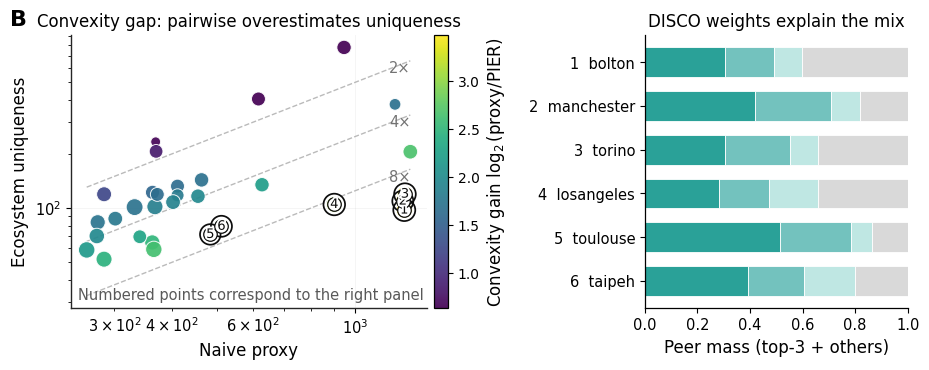

In [71]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe


def apply_nature_style():
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.12,
        "grid.linewidth": 0.7,
        "legend.frameon": False,
    })


def plot_fig5B_convexity_gap_v2(
    summary_csv: str = "../results/tables/exp14_multicity_tabular_summary.csv",
    save_path: str = None,
    proxy_col: str = "PairwiseMeanAbsDiff",   # or "ClosestPeerMeanAbsDiff"
    topk: int = 6,
):
    """
    Fig.5B (v2): Remove city-name labels from the scatter to avoid occlusion.
    Instead:
      - Left: highlight top-k convexity-gain cities with numbered callouts.
      - Right: show those city names (prefixed with the same numbers) plus top peers.

    Left panel semantics:
      x = 1000 * proxy / flow   (‰)
      y = 1000 * PIER  / flow   (‰)
      color = log2(proxy/PIER)  (convexity gain)
      size = WeightEntropyNorm  (mixture complexity)

    Right panel explains the convex mix via top-3 peer weights.
    """

    apply_nature_style()

    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Missing file: {summary_csv}")

    df = pd.read_csv(summary_csv)

    req = {
        "City", "MeanFlow_Test", "PIER",
        proxy_col,
        "TopPeer1", "TopPeer1Weight", "TopPeer2", "TopPeer2Weight", "TopPeer3", "TopPeer3Weight",
        "WeightEntropyNorm"
    }
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

    d = df.copy()

    # numeric conversions
    for c in ["MeanFlow_Test", "PIER", proxy_col, "TopPeer1Weight", "TopPeer2Weight", "TopPeer3Weight", "WeightEntropyNorm"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=["MeanFlow_Test", "PIER", proxy_col]).copy()

    eps = 1e-12
    d["pier_rel"]  = 1000.0 * d["PIER"] / (d["MeanFlow_Test"].abs() + eps)
    d["proxy_rel"] = 1000.0 * d[proxy_col] / (d["MeanFlow_Test"].abs() + eps)
    d["gain_log2"] = np.log2((d["proxy_rel"] + eps) / (d["pier_rel"] + eps))

    # marker size from entropy (0..1)
    ent = d["WeightEntropyNorm"].fillna(0.0).clip(0.0, 1.0).to_numpy()
    d["ms"] = 45.0 + 140.0 * ent

    # pick top-k largest convexity gain (most misleading under naive proxy)
    top = d.sort_values("gain_log2", ascending=False).head(int(topk)).copy()
    top["rank"] = np.arange(1, len(top) + 1)  # 1..K, consistent mapping across panels

    # ---- layout
    fig = plt.figure(figsize=(9.2, 3.9))
    gs = GridSpec(1, 2, figure=fig, width_ratios=[1.45, 1.0], wspace=0.6)
    ax  = fig.add_subplot(gs[0, 0])
    axw = fig.add_subplot(gs[0, 1])

    # ---- left panel: scatter + iso-gain lines
    ax.grid(True, linewidth=0.7, alpha=0.12)
    ax.set_axisbelow(True)

    x = d["proxy_rel"].to_numpy(dtype=float)
    y = d["pier_rel"].to_numpy(dtype=float)

    # color scale (robust)
    vmin = float(np.nanpercentile(d["gain_log2"], 5))
    vmax = float(np.nanpercentile(d["gain_log2"], 95))
    vmin, vmax = max(vmin, -0.2), max(vmax, vmin + 0.2)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    sc = ax.scatter(
        x, y,
        c=d["gain_log2"].to_numpy(dtype=float),
        s=d["ms"].to_numpy(dtype=float),
        cmap="viridis",
        norm=norm,
        alpha=0.92,
        edgecolor="white",
        linewidth=0.7,
        zorder=3
    )

    ax.set_xscale("log")
    ax.set_yscale("log")

    xmin = float(np.nanmin(x))
    xmax = float(np.nanmax(x))
    xx = np.logspace(np.log10(max(xmin, 1e-6)), np.log10(xmax), 200)

    for k, lab in [(2, "2×"), (4, "4×"), (8, "8×")]:
        yy = xx / k
        ax.plot(xx, yy, color="0.70", lw=1.0, ls="--", alpha=0.9, zorder=1)
        ax.text(xx[-1], yy[-1], lab, fontsize=10.5, color="0.45",
                ha="right", va="top")

    # highlight points corresponding to the right panel (NO city names here)
    tx = top["proxy_rel"].to_numpy(dtype=float)
    ty = top["pier_rel"].to_numpy(dtype=float)
    tr = top["rank"].to_numpy(dtype=int)

    # ring highlight
    ax.scatter(
        tx, ty,
        s=(top["ms"].to_numpy(dtype=float) + 120.0),
        facecolors="none",
        edgecolors="0.05",
        linewidths=1.25,
        zorder=5
    )
    # small white badge for rank number (sits on top of points, readable)
    ax.scatter(
        tx, ty,
        s=95,
        facecolors="white",
        edgecolors="0.05",
        linewidths=0.9,
        zorder=6
    )
    for (xpi, ypi, ri) in zip(tx, ty, tr):
        ax.text(
            xpi, ypi, str(int(ri)),
            ha="center", va="center",
            fontsize=9.4, color="0.05",
            zorder=7,
            path_effects=[pe.withStroke(linewidth=2.6, foreground="white")]
        )

    ax.set_xlabel(f"Naive proxy") # : 1000× {proxy_col}/flow (‰)
    ax.set_ylabel("Ecosystem uniqueness") # 1000× PIER/flow (‰)
    ax.set_title("Convexity gap: pairwise overestimates uniqueness", pad=6)

    cb = fig.colorbar(sc, ax=ax, fraction=0.046, pad=0.02)
    cb.set_label(r"Convexity gain $\log_2(\mathrm{proxy}/\mathrm{PIER})$")
    cb.ax.tick_params(labelsize=10)

    # small key
    ax.text(
        0.02, 0.02,
        "Numbered points correspond to the right panel",
        transform=ax.transAxes,
        fontsize=10.5, color="0.35",
        ha="left", va="bottom"
    )

    ax.text(-0.17, 1.02, "B", transform=ax.transAxes,
            fontsize=16, fontweight="bold", va="bottom")



    # ---- right panel: stacked weights for top-k
    axw.grid(False)

    # show highest gain at top
    top_r = top.sort_values("rank", ascending=True).copy()
    ylabels = [f"{int(r)}  {c}" for r, c in zip(top_r["rank"], top_r["City"].astype(str))]
    yidx = np.arange(len(top_r))

    C1, C2, C3, C4 = "#2AA198", "#73C2BE", "#BFE7E3", "0.85"  # teal ladder + gray

    w1 = top_r["TopPeer1Weight"].fillna(0.0).to_numpy(dtype=float)
    w2 = top_r["TopPeer2Weight"].fillna(0.0).to_numpy(dtype=float)
    w3 = top_r["TopPeer3Weight"].fillna(0.0).to_numpy(dtype=float)
    s3 = np.maximum(w1, 0) + np.maximum(w2, 0) + np.maximum(w3, 0)
    others = np.maximum(0.0, 1.0 - s3)

    axw.barh(yidx, w1, color=C1, edgecolor="white", linewidth=0.6, height=0.68)
    axw.barh(yidx, w2, left=w1, color=C2, edgecolor="white", linewidth=0.6, height=0.68)
    axw.barh(yidx, w3, left=w1 + w2, color=C3, edgecolor="white", linewidth=0.6, height=0.68)
    axw.barh(yidx, others, left=w1 + w2 + w3, color=C4, edgecolor="white", linewidth=0.6, height=0.68)

    axw.set_yticks(yidx)
    axw.set_yticklabels(ylabels, fontsize=10.5)
    axw.set_xlim(0.0, 1.0)
    axw.set_xlabel("Peer mass (top-3 + others)")
    axw.set_title("DISCO weights explain the mix", pad=6)
    axw.invert_yaxis()

    # right-side text: top peers + gain
    for i, row in enumerate(top_r.itertuples(index=False)):
        p1 = str(row.TopPeer1)
        p2 = str(row.TopPeer2)
        p3 = str(row.TopPeer3)
        g  = float(row.gain_log2)
        # axw.text(
        #     1.02, i,
        #     f"top: {p1}, {p2}, {p3}",
        #     ha="left", va="center",
        #     fontsize=9.4, color="0.25",
        #     transform=axw.get_yaxis_transform()
        # )

    # for sp in ax.spines.values():
    #     sp.set_visible(False)
    # for sp in axw.spines.values():
    #     sp.set_visible(False)

    # Show axis lines for the left panel (keep Nature-style: left & bottom only)
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_color("0.15")
    ax.spines["bottom"].set_color("0.15")


    fig.subplots_adjust(left=0.07, right=0.98, top=0.90, bottom=0.20)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig5B_convexity_gap_v2(
    summary_csv="../results/tables/exp14_multicity_tabular_summary.csv",
    save_path="../results/figures/fig5B_convexity_gap.pdf",
    proxy_col="PairwiseMeanAbsDiff",
    topk=6
);


Saved: ../results/figures/fig5C_multicity_geometry.pdf


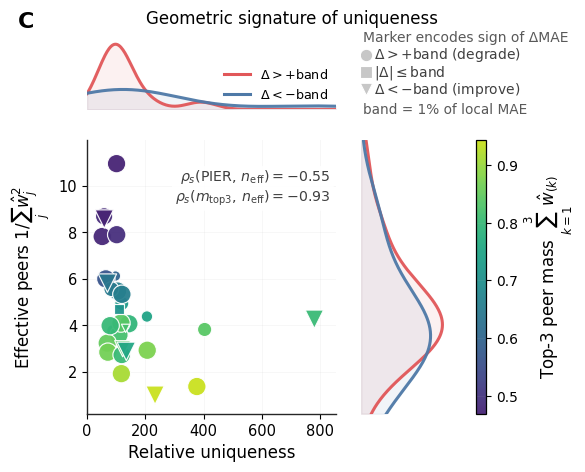

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon
from matplotlib.lines import Line2D

# -------------------------
# Style
# -------------------------
def apply_nature_style():
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.10,
        "grid.linewidth": 0.7,
        "legend.frameon": False,
    })


def truncate_cmap(cmap, minval=0.10, maxval=0.92, n=256):
    return mcolors.LinearSegmentedColormap.from_list(
        f"trunc({cmap.name},{minval:.2f},{maxval:.2f})",
        cmap(np.linspace(minval, maxval, n))
    )


# -------------------------
# Simple Gaussian KDE (numpy-only, no seaborn/scipy)
# -------------------------
def kde_1d(x, grid, bw=None):
    """
    Gaussian KDE on a fixed grid.
    - x: samples (1D)
    - grid: evaluation points
    - bw: bandwidth; if None, Scott's rule.
    Returns density on grid.
    """
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    n = x.size
    if n < 2:
        return np.zeros_like(grid)

    std = float(np.std(x, ddof=1))
    if bw is None:
        # Scott's rule
        bw = 1.06 * std * (n ** (-1.0 / 5.0))

    bw = float(max(bw, 1e-12))
    z = (grid[:, None] - x[None, :]) / bw
    dens = np.exp(-0.5 * z * z).sum(axis=1) / (n * bw * np.sqrt(2 * np.pi))
    return dens


# -------------------------
# Fig.5C (v2)
# -------------------------
def plot_fig5C_multicity_geometry_v2(
    summary_csv: str = "../results/tables/exp14_multicity_tabular_summary.csv",
    save_path: str = None,
    band_pct: float = 1.0,
    kde_points: int = 250,
):
    """
    Fig.5C (v2): clean joint layout + KDE marginals (no overlap).

    Main panel:
      x = 1000 * PIER / mean_flow (‰)
      y = effective peers = 1 / sum(w^2)  (EffectivePeers_HHI)
      color = TopKMass3 (top-3 peer mass)
      marker = sign of impact (degrade / near-zero / improve)

    Top marginal: KDE of x by marker category
    Right marginal: KDE of y by marker category
    Top-right panel: legend + simplex schematic (separate axis, no overlap)
    Colorbar: separate axis
    """

    apply_nature_style()

    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Summary CSV not found: {summary_csv}")

    df = pd.read_csv(summary_csv)

    req = {
        "City", "MeanFlow_Test", "PIER",
        "EffectivePeers_HHI", "TopKMass3",
        "Delta_Router", "Local_MAE", "NumTest"
    }
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing columns {missing}. Found: {list(df.columns)}")

    d = df.copy()
    for c in ["MeanFlow_Test", "PIER", "EffectivePeers_HHI", "TopKMass3", "Delta_Router", "Local_MAE", "NumTest"]:
        d[c] = pd.to_numeric(d[c], errors="coerce")
    d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=list(req)).copy()

    eps = 1e-12

    # x: relative uniqueness (‰)
    d["pier_rel"] = 1000.0 * d["PIER"] / (d["MeanFlow_Test"].abs() + eps)

    # y: effective peers (mix complexity)
    d["eff_peers"] = d["EffectivePeers_HHI"].astype(float)

    # color: top-3 peer mass
    d["top3"] = d["TopKMass3"].astype(float).clip(0.0, 1.0)

    # signed impact (%)
    d["impact_pct"] = 100.0 * d["Delta_Router"] / (d["Local_MAE"].abs() + eps)

    band = float(band_pct)
    d["cat"] = np.where(
        d["impact_pct"] > band, "degrade",
        np.where(d["impact_pct"] < -band, "improve", "near-zero")
    )

    MARKER = {"degrade": "o", "near-zero": "s", "improve": "v"}
    CAT_COL = {"degrade": "#E15759", "near-zero": "0.35", "improve": "#4E79A7"}
    CAT_LABEL = {
        "degrade": r"$\Delta>+{\rm band}$ (degrade)",
        "near-zero": r"$|\Delta|\leq {\rm band}$",
        "improve": r"$\Delta<-{\rm band}$ (improve)"
    }

    # point sizes (sqrt scaling with NumTest)
    n = np.clip(d["NumTest"].to_numpy(dtype=float), 1.0, None)
    s = 36.0 + 140.0 * (np.sqrt(n) - np.sqrt(n.min())) / (np.sqrt(n.max()) - np.sqrt(n.min()) + 1e-12)
    d["ms"] = s

    # colormap
    cmap = truncate_cmap(plt.get_cmap("viridis"), 0.10, 0.92)
    vmin = float(np.nanpercentile(d["top3"], 5))
    vmax = float(np.nanpercentile(d["top3"], 95))
    vmin = max(0.0, min(vmin, 0.7))
    vmax = max(vmin + 0.15, min(max(vmax, 0.8), 1.0))
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    # -------------------------
    # Layout (NO OVERLAP):
    #   [top KDE | key panel |   ]
    #   [main    | right KDE | cbar]
    # -------------------------
    fig = plt.figure(figsize=(5.7, 4.7))
    gs = GridSpec(
        2, 3,
        figure=fig,
        width_ratios=[5.0, 1.8, 0.20],
        height_ratios=[1.05, 4.0],
        wspace=0.22,
        hspace=0.18,
    )

    ax_top = fig.add_subplot(gs[0, 0])
    ax     = fig.add_subplot(gs[1, 0], sharex=ax_top)
    ax_key = fig.add_subplot(gs[0, 1])     # legend + schematic (separate)
    ax_r   = fig.add_subplot(gs[1, 1], sharey=ax)
    cax    = fig.add_subplot(gs[1, 2])

    ax_key.axis("off")

    # -------------------------
    # Main scatter
    # -------------------------
    ax.grid(True, linewidth=0.7, alpha=0.10)
    ax.set_axisbelow(True)

    sc_last = None
    for cat in ["degrade", "near-zero", "improve"]:
        sub = d[d["cat"] == cat]
        if sub.empty:
            continue
        sc = ax.scatter(
            sub["pier_rel"], sub["eff_peers"],
            s=sub["ms"],
            c=sub["top3"], cmap=cmap, norm=norm,
            marker=MARKER[cat],
            edgecolor="white",
            linewidth=0.85,
            alpha=0.95,
            zorder=3
        )
        sc_last = sc

    ax.set_xlabel(r"Relative uniqueness") # : $1000\times{\rm PIER}/\overline{\rm flow}$ (‰)
    ax.set_ylabel(r"Effective peers $1/\sum_j\hat{w}_j^2$")

    # Keep only left/bottom spines visible and crisp
    ax.spines["left"].set_visible(True)
    ax.spines["bottom"].set_visible(True)
    ax.spines["left"].set_linewidth(1.0)
    ax.spines["bottom"].set_linewidth(1.0)
    ax.spines["left"].set_color("0.15")
    ax.spines["bottom"].set_color("0.15")

    # Limits
    x = d["pier_rel"].to_numpy(dtype=float)
    y = d["eff_peers"].to_numpy(dtype=float)
    xmin, xmax = float(np.nanmin(x)), float(np.nanmax(x))
    ymin, ymax = float(np.nanmin(y)), float(np.nanmax(y))
    ax.set_xlim(max(0.0, xmin - 0.08 * (xmax - xmin + 1e-12)), xmax + 0.10 * (xmax - xmin + 1e-12))
    ax.set_ylim(max(0.0, ymin - 0.08 * (ymax - ymin + 1e-12)), ymax + 0.10 * (ymax - ymin + 1e-12))

    # -------------------------
    # Spearman rho annotations (top-right of main panel)
    # -------------------------
    rho_pier_eff = d[["pier_rel", "eff_peers"]].dropna().corr(method="spearman").iloc[0, 1]
    rho_top3_eff = d[["top3", "eff_peers"]].dropna().corr(method="spearman").iloc[0, 1]

    ax.text(
        0.98, 0.9,
        rf"$\rho_s(\mathrm{{PIER}},\,n_\mathrm{{eff}})={rho_pier_eff:.2f}$" "\n"
        rf"$\rho_s(m_{{\rm top3}},\,n_\mathrm{{eff}})={rho_top3_eff:.2f}$",
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=10.2,
        color="0.25",
        bbox=dict(boxstyle="round,pad=0.22", facecolor="white", edgecolor="none", alpha=0.88),
        zorder=20,
    )

    # Figure title (avoid overlap with top KDE)
    fig.suptitle("Geometric signature of uniqueness", y=0.97, fontsize=12)

    # -------------------------
    # Top KDE (x)
    # -------------------------
    ax_top.grid(False)
    ax_top.tick_params(axis="x", bottom=False, labelbottom=False)
    ax_top.set_yticks([])
    for sp in ax_top.spines.values():
        sp.set_visible(False)

    x0, x1 = ax.get_xlim()
    grid_x = np.linspace(x0, x1, int(kde_points))

    max_d = 0.0
    for cat in ["degrade", "near-zero", "improve"]:
        subx = d.loc[d["cat"] == cat, "pier_rel"].to_numpy(dtype=float)
        if subx.size < 2:
            continue
        dens = kde_1d(subx, grid_x)
        max_d = max(max_d, float(np.nanmax(dens)))
        ax_top.plot(grid_x, dens, color=CAT_COL[cat], lw=2.2, alpha=0.95)
        ax_top.fill_between(grid_x, 0, dens, color=CAT_COL[cat], alpha=0.08)

    if max_d > 0:
        ax_top.set_ylim(0, 1.10 * max_d)
        
    kde_handles = [
        Line2D([0],[0], color=CAT_COL["degrade"], lw=2.2, label=r"$\Delta>+{\rm band}$"),
        # Line2D([0],[0], color=CAT_COL["near-zero"], lw=2.2, label=r"$|\Delta|\leq{\rm band}$"),
        Line2D([0],[0], color=CAT_COL["improve"], lw=2.2, label=r"$\Delta<-{\rm band}$"),
    ]

    ax_top.legend(
        handles=kde_handles,
        loc="lower right",
        fontsize=9.2,
        frameon=False,
        handlelength=2.0,
        borderaxespad=0.2
    )

    # -------------------------
    # Right KDE (y)
    # -------------------------
    ax_r.grid(False)
    ax_r.set_xticks([])
    ax_r.tick_params(axis="y", left=False, labelleft=False)
    for sp in ax_r.spines.values():
        sp.set_visible(False)

    y0, y1 = ax.get_ylim()
    grid_y = np.linspace(y0, y1, int(kde_points))

    max_dr = 0.0
    for cat in ["degrade", "near-zero", "improve"]:
        suby = d.loc[d["cat"] == cat, "eff_peers"].to_numpy(dtype=float)
        if suby.size < 2:
            continue
        dens = kde_1d(suby, grid_y)
        max_dr = max(max_dr, float(np.nanmax(dens)))
        ax_r.plot(dens, grid_y, color=CAT_COL[cat], lw=2.2, alpha=0.95)
        ax_r.fill_betweenx(grid_y, 0, dens, color=CAT_COL[cat], alpha=0.08)

    if max_dr > 0:
        ax_r.set_xlim(0, 1.10 * max_dr)

    # -------------------------
    # Colorbar
    # -------------------------
    cb = fig.colorbar(sc_last, cax=cax)
    cb.set_label(r"Top-3 peer mass $\sum_{k=1}^3 \hat{w}_{(k)}$")
    cb.ax.tick_params(labelsize=10)

    # -------------------------
    # Key panel (legend + simplex schematic) — separate, no overlap
    # -------------------------
    ax_key.set_xlim(0, 1)
    ax_key.set_ylim(0, 1)

    ax_key.text(0.02, 1.10, "Marker encodes sign of ΔMAE", fontsize=10.0, color="0.35", va="top")

    y_pos = {"degrade": 0.76, "near-zero": 0.52, "improve": 0.28}
    for cat in ["degrade", "near-zero", "improve"]:
        ax_key.scatter([0.06], [y_pos[cat]], s=80, marker=MARKER[cat],
                       facecolor="0.78", edgecolor="white", linewidth=0.8)
        ax_key.text(0.14, y_pos[cat], CAT_LABEL[cat], fontsize=10.0, color="0.25", va="center")

    ax_key.text(0.02, -0.10, f"band = {band_pct:.0f}% of local MAE", fontsize=9.8, color="0.35", va="bottom")

    # # Small schematic (right side of the key panel)
    # tri = np.array([[0.62, 0.20], [0.95, 0.20], [0.785, 0.56]])
    # ax_key.add_patch(Polygon(tri, closed=True, facecolor="0.96", edgecolor="0.55", lw=1.0))
    # ax_key.scatter(tri[:, 0], tri[:, 1], s=36, color="0.40", zorder=3)
    # ax_key.text(0.62, 0.66, "schematic:\nconvex mix → target", fontsize=9.4, color="0.35", va="top")

    # mix = np.array([0.79, 0.30])
    # tgt = np.array([0.90, 0.48])
    # ax_key.scatter([mix[0]], [mix[1]], s=55, marker="D", facecolor="white", edgecolor="0.25", lw=1.0, zorder=4)
    # ax_key.scatter([tgt[0]], [tgt[1]], s=75, marker="*", color="#E15759", edgecolor="white", lw=0.7, zorder=5)
    # ax_key.annotate("", xy=(tgt[0], tgt[1]), xytext=(mix[0], mix[1]),
    #                 arrowprops=dict(arrowstyle="-|>", lw=1.1, color="0.25", alpha=0.9))

    # Final spacing
    fig.subplots_adjust(left=0.14, right=0.84, bottom=0.11, top=0.91)
    # Panel label
    ax.text(-0.28, 1.40, "C", transform=ax.transAxes,
            fontsize=16, fontweight="bold", va="bottom")

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig5C_multicity_geometry_v2(
    summary_csv="../results/tables/exp14_multicity_tabular_summary.csv",
    save_path="../results/figures/fig5C_multicity_geometry.pdf",
    band_pct=1.0
);


Saved: ../results/figures/fig5D_ecosystem_weight_map.pdf


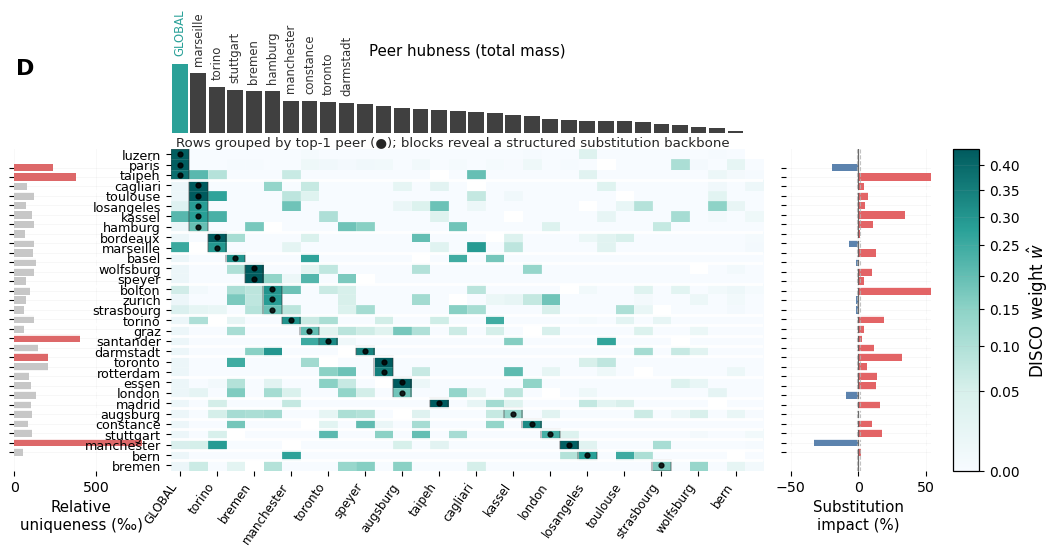

In [95]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle


# -------------------------
# Style helpers (keep consistent across Fig.5A–E)
# -------------------------
def apply_nature_style():
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10.2,
        "ytick.labelsize": 10.2,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.10,
        "grid.linewidth": 0.7,
        "legend.frameon": False,
    })


def _pick_col(df: pd.DataFrame, candidates):
    """Pick a column name from candidates using case-insensitive matching."""
    cols = list(df.columns)
    low = {c.lower(): c for c in cols}
    for c in candidates:
        if c in cols:
            return c
        if c.lower() in low:
            return low[c.lower()]
    return None


def _teal_weight_cmap():
    """A clean sequential teal colormap (Nature-friendly)."""
    return LinearSegmentedColormap.from_list(
        "teal_seq",
        ["#F7FBFF", "#D7F0EB", "#8ED3C7", "#2AA198", "#005B5E"]
    )


# -------------------------
# Fig.5D
# -------------------------
def plot_fig5D_ecosystem_weight_map(
    summary_csv: str = "../results/tables/exp14_multicity_tabular_summary.csv",
    weights_long_csv: str = "../results/tables/exp14_multicity_tabular_summary_peer_weights_long.csv",
    save_path: str = None,
    band_pct: float = 1.0,
    max_peers: int = None,           # optionally keep only top-N peers by hubness
    show_peer_labels_every: int = 2, # reduce x label clutter (1 = show all)
    gamma: float = 0.65,             # NEW: boost low weights via PowerNorm
):
    """
    Fig.5D: Ecosystem substitution map (DISCO weights).

    Key story we want to make explicit:
      - Rows are grouped by the identity of the top-1 peer (dominant substitute).
      - Black dots mark the top-1 peer per target.
      - Block boundaries + staircase highlights reveal a structured "substitution backbone",
        not a trivial diagonal.

    Layout:
      - Top: peer hubness (column total mass)
      - Center: weight heatmap (target x peer)
      - Left: relative uniqueness (1000*PIER/flow)  [‰, not %]
      - Right: substitution impact (% of local MAE)
      - Overlay: black dot marks the top-1 peer for each target row
    """

    apply_nature_style()

    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Missing summary CSV: {summary_csv}")

    summ = pd.read_csv(summary_csv)

    req = {"City", "MeanFlow_Test", "PIER", "Local_MAE", "Delta_Router",
           "TopPeer1", "TopPeer1Weight", "TopPeer2", "TopPeer2Weight", "TopPeer3", "TopPeer3Weight"}
    missing = req - set(summ.columns)
    if missing:
        raise ValueError(f"Missing columns in summary: {missing}")

    for c in ["MeanFlow_Test", "PIER", "Local_MAE", "Delta_Router",
              "TopPeer1Weight", "TopPeer2Weight", "TopPeer3Weight"]:
        summ[c] = pd.to_numeric(summ[c], errors="coerce")

    summ = summ.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["City", "MeanFlow_Test", "PIER", "Local_MAE"]
    ).copy()
    summ["City"] = summ["City"].astype(str).str.strip()

    eps = 1e-12
    summ["pier_rel"] = 1000.0 * summ["PIER"] / (summ["MeanFlow_Test"].abs() + eps)  # per-mille scale
    summ["impact_pct"] = 100.0 * summ["Delta_Router"] / (summ["Local_MAE"].abs() + eps)

    band = float(band_pct)
    summ["impact_cat"] = np.where(
        summ["impact_pct"] > band, "degrade",
        np.where(summ["impact_pct"] < -band, "improve", "near-zero")
    )
    CAT_COL = {"degrade": "#E15759", "improve": "#4E79A7", "near-zero": "0.55"}

    # -------------------------
    # Load weights
    # -------------------------
    if os.path.exists(weights_long_csv):
        wlong = pd.read_csv(weights_long_csv)

        col_tgt = _pick_col(wlong, ["City", "TargetCity", "Target", "target", "target_city"])
        col_peer = _pick_col(wlong, ["Peer", "PeerCity", "peer", "peer_city", "PeerName", "peer_name"])
        col_w = _pick_col(wlong, ["Weight", "weight", "w_hat", "w", "PeerWeight", "peer_weight"])

        if col_tgt is None or col_peer is None or col_w is None:
            raise ValueError(
                "Cannot infer columns in weights_long_csv. "
                "Expected (Target, Peer, Weight). "
                f"Found columns: {list(wlong.columns)}"
            )

        wlong[col_tgt] = wlong[col_tgt].astype(str).str.strip()
        wlong[col_peer] = wlong[col_peer].astype(str).str.strip()
        wlong[col_w] = pd.to_numeric(wlong[col_w], errors="coerce")
        wlong = wlong.replace([np.inf, -np.inf], np.nan).dropna(subset=[col_tgt, col_peer, col_w]).copy()

        W = wlong.pivot_table(
            index=col_tgt,
            columns=col_peer,
            values=col_w,
            aggfunc="mean",
            fill_value=0.0
        )
    else:
        # Fallback: only top-3 + OTHERS
        peers = pd.unique(
            pd.concat([
                summ["TopPeer1"].astype(str),
                summ["TopPeer2"].astype(str),
                summ["TopPeer3"].astype(str),
            ], axis=0).str.strip()
        ).tolist()
        peers = [p for p in peers if p and p.lower() != "nan"]
        if "OTHERS" not in peers:
            peers.append("OTHERS")

        W = pd.DataFrame(0.0, index=summ["City"].tolist(), columns=peers)

        for r in summ.itertuples(index=False):
            tgt = str(r.City).strip()
            for p, w in [(r.TopPeer1, r.TopPeer1Weight),
                         (r.TopPeer2, r.TopPeer2Weight),
                         (r.TopPeer3, r.TopPeer3Weight)]:
                if pd.isna(p) or pd.isna(w):
                    continue
                W.loc[tgt, str(p).strip()] += float(w)

            s3 = float(np.nansum([r.TopPeer1Weight, r.TopPeer2Weight, r.TopPeer3Weight]))
            W.loc[tgt, "OTHERS"] = max(0.0, 1.0 - s3)

    W.index = W.index.astype(str).str.strip()
    W.columns = W.columns.astype(str).str.strip()

    keep_rows = [c for c in summ["City"].tolist() if c in W.index]
    W = W.loc[keep_rows].copy()

    # NEW: explicitly remove self-peers (if any) and renormalize
    for city in W.index:
        if city in W.columns:
            W.loc[city, city] = 0.0

    rs = W.sum(axis=1).replace(0.0, np.nan)
    W = W.div(rs, axis=0).fillna(0.0)

    # Optional: keep only top-N peers by hubness
    hub = W.sum(axis=0).sort_values(ascending=False)
    if max_peers is not None:
        max_peers = int(max_peers)
        keep_cols = hub.index[:max_peers].tolist()
        W = W[keep_cols].copy()
        hub = W.sum(axis=0).sort_values(ascending=False)

    # Put GLOBAL first
    if "GLOBAL" in W.columns:
        cols = ["GLOBAL"] + [c for c in W.columns if c != "GLOBAL"]
        W = W[cols]
        hub = W.sum(axis=0)

    # Dominant peer per row
    W_for_argmax = W.copy()
    for city in W_for_argmax.index:
        if city in W_for_argmax.columns:
            W_for_argmax.loc[city, city] = np.nan

    top_peer = W_for_argmax.idxmax(axis=1)
    top_w = W_for_argmax.max(axis=1)

    # Row ordering: group by dominant peer, then by dominant weight, then by uniqueness
    hub_rank = {p: i for i, p in enumerate(hub.sort_values(ascending=False).index.tolist())}
    row_meta = pd.DataFrame({
        "City": W.index,
        "top_peer": top_peer.values,
        "top_w": top_w.values,
    }).set_index("City")

    summ_m = summ.set_index("City")
    row_meta["pier_rel"] = summ_m.loc[W.index, "pier_rel"].values
    row_meta["impact_pct"] = summ_m.loc[W.index, "impact_pct"].values
    row_meta["peer_rank"] = row_meta["top_peer"].map(lambda p: hub_rank.get(p, 999))

    row_order = row_meta.sort_values(
        ["peer_rank", "top_w", "pier_rel"],
        ascending=[True, False, False]
    ).index.tolist()

    W = W.loc[row_order].copy()
    W_for_argmax = W_for_argmax.loc[row_order].copy()
    row_meta = row_meta.loc[row_order].copy()

    # Final column order by hubness (GLOBAL pinned if present)
    hub = W.sum(axis=0).sort_values(ascending=False)
    col_order = hub.index.tolist()
    if "GLOBAL" in W.columns:
        col_order = ["GLOBAL"] + [c for c in col_order if c != "GLOBAL"]
    W = W[col_order].copy()
    W_for_argmax = W_for_argmax[col_order].copy()
    hub = W.sum(axis=0).sort_values(ascending=False)

    # NEW: block boundaries where dominant peer changes
    tp = row_meta["top_peer"].astype(str).to_numpy()
    breaks = np.where(tp[:-1] != tp[1:])[0]  # boundary after index b
    starts = np.r_[0, breaks + 1]
    ends = np.r_[breaks, len(tp) - 1]
    blocks = [(int(s), int(e), tp[int(s)]) for s, e in zip(starts, ends)]

    # Display matrix (mask diagonal if present)
    W_disp = W.copy()
    for city in W_disp.index:
        if city in W_disp.columns:
            W_disp.loc[city, city] = np.nan
    A = np.ma.masked_invalid(W_disp.values)

    # Color scaling + NEW: PowerNorm to reveal sparse structure
    vmax = float(np.nanpercentile(W_disp.values, 99))
    vmax = max(vmax, 0.20)
    vmin = 0.0
    norm = mcolors.PowerNorm(gamma=float(gamma), vmin=vmin, vmax=vmax)

    cmap = _teal_weight_cmap()
    cmap.set_bad(color="white")

    # -------------------------
    # Figure layout
    # -------------------------
    n_rows, n_cols = W.shape

    fig = plt.figure(figsize=(10.6, 5.7))
    gs = GridSpec(
        2, 4,
        figure=fig,
        height_ratios=[1.0, 4.4],
        width_ratios=[1.15, 5.1, 1.25, 0.22],
        hspace=0.08,
        wspace=0.10
    )

    ax_left  = fig.add_subplot(gs[1, 0])
    ax_top   = fig.add_subplot(gs[0, 1])
    ax_hm    = fig.add_subplot(gs[1, 1])
    ax_right = fig.add_subplot(gs[1, 2])
    cax      = fig.add_subplot(gs[1, 3])

    # -------------------------
    # Heatmap
    # -------------------------
    ax_hm.grid(False)
    im = ax_hm.imshow(A, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")

    # NEW: lightly highlight GLOBAL column (helps locate the hub visually)
    if "GLOBAL" in W.columns:
        jg = list(W.columns).index("GLOBAL")
        ax_hm.axvspan(jg - 0.5, jg + 0.5, color="#2AA198", alpha=0.05, lw=0, zorder=0)

    # Ticks
    ax_hm.set_yticks(np.arange(n_rows))
    ax_hm.set_yticklabels(W.index.tolist(), fontsize=9.2)

    peer_labels = W.columns.tolist()
    xt, xl = [], []
    for j, p in enumerate(peer_labels):
        if (show_peer_labels_every == 1) or (j % int(show_peer_labels_every) == 0) or (p == "GLOBAL"):
            xt.append(j)
            xl.append(p)
    ax_hm.set_xticks(xt)
    ax_hm.set_xticklabels(xl, rotation=55, ha="right", fontsize=8.6)

    # Subtle cell separators
    ax_hm.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax_hm.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax_hm.grid(which="minor", color="white", linewidth=0.6, alpha=0.14)
    ax_hm.tick_params(which="minor", bottom=False, left=False)

    # Top-1 peer dots (use W_for_argmax to avoid diagonal/self)
    topj = np.nanargmax(W_for_argmax.values, axis=1)
    ax_hm.scatter(topj, np.arange(n_rows), s=12.0, color="black", alpha=0.85, zorder=6)

    # NEW: staircase highlight rectangles for each dominant-peer block
    for s, e, p in blocks:
        if p in W.columns:
            j = list(W.columns).index(p)
            ax_hm.add_patch(Rectangle(
                (j - 0.5, s - 0.5),
                1.0,
                (e - s + 1.0),
                facecolor="none",
                edgecolor="0.15",
                linewidth=1.2,
                alpha=0.35,
                zorder=7
            ))

    # NEW: draw block boundary lines (across all aligned panels)
    for b in breaks:
        yline = b + 0.5
        for a in (ax_left, ax_hm, ax_right):
            a.axhline(yline, color="white", lw=2.0, alpha=0.95, zorder=8)

    # Small in-panel explainer (prevents misread of the diagonal)
    ax_hm.text(
        0.01, 1.00,
        "Rows grouped by top-1 peer (●); blocks reveal a structured substitution backbone",
        transform=ax_hm.transAxes,
        ha="left", va="bottom",
        fontsize=9.6,
        color="0.15"
    )

    # Clean spines
    for sp in ax_hm.spines.values():
        sp.set_visible(False)

    # Colorbar
    cb = fig.colorbar(im, cax=cax)
    cb.set_label(r"DISCO weight $\hat{w}$")
    cb.ax.tick_params(labelsize=10)

    # -------------------------
    # Top: peer hubness
    # -------------------------
    ax_top.grid(False)
    hub_vals = hub.loc[W.columns].to_numpy(dtype=float)
    hub_vals = hub_vals / (hub_vals.sum() + eps)

    ax_top.bar(np.arange(n_cols), hub_vals, color="0.25", width=0.85)
    if "GLOBAL" in W.columns:
        jg = list(W.columns).index("GLOBAL")
        ax_top.bar(jg, hub_vals[jg], color="#2AA198", width=0.85)

    # NEW: annotate top hub peers (top-4)
    topk = min(10, n_cols)
    idx = np.argsort(-hub_vals)[:topk]
    for j in idx:
        name = W.columns[j]
        ax_top.text(
            j, hub_vals[j] + 0.01,
            name,
            ha="center", va="bottom",
            fontsize=8.4, rotation=90,
            color=("#2AA198" if name == "GLOBAL" else "0.20")
        )

    ax_top.set_xlim(-0.5, n_cols - 0.5)
    ax_top.set_xticks([])
    ax_top.set_yticks([])
    ax_top.set_title("Peer hubness (total mass)", fontsize=10.8, pad=4)
    for sp in ax_top.spines.values():
        sp.set_visible(False)

    # -------------------------
    # Left: relative uniqueness (aligned)
    # -------------------------
    ax_left.grid(True, axis="x", linewidth=0.6, alpha=0.10)
    ax_left.set_axisbelow(True)

    u = row_meta["pier_rel"].to_numpy(dtype=float)
    ax_left.barh(np.arange(n_rows), u, color="0.78", height=0.82, edgecolor="none")

    # highlight top-5 uniqueness
    if n_rows >= 5:
        idx_top = np.argsort(-u)[:5]
        ax_left.barh(idx_top, u[idx_top], color="#E15759", height=0.82, alpha=0.85, edgecolor="none")

    ax_left.set_yticks(np.arange(n_rows))
    ax_left.set_yticklabels([])
    ax_left.invert_yaxis()

    # IMPORTANT: this is per-mille (1000×), not percent
    ax_left.set_xlabel(r"Relative" + "\n" + r"uniqueness (‰)", fontsize=10.8)

    for sp in ax_left.spines.values():
        sp.set_visible(False)

    # -------------------------
    # Right: substitution impact
    # -------------------------
    ax_right.grid(True, axis="x", linewidth=0.6, alpha=0.10)
    ax_right.set_axisbelow(True)

    imp = row_meta["impact_pct"].to_numpy(dtype=float)
    cats = summ_m.loc[W.index, "impact_cat"].tolist()
    colors = [CAT_COL.get(c, "0.55") for c in cats]

    ax_right.barh(np.arange(n_rows), imp, color=colors, height=0.82, edgecolor="none", alpha=0.92)
    ax_right.axvline(0.0, color="0.35", lw=0.9, alpha=0.9)
    ax_right.axvline(+band, color="0.70", lw=0.8, ls="--", alpha=0.8)
    ax_right.axvline(-band, color="0.70", lw=0.8, ls="--", alpha=0.8)

    ax_right.set_yticks(np.arange(n_rows))
    ax_right.set_yticklabels([])
    ax_right.invert_yaxis()
    ax_right.set_xlabel("Substitution" + "\n" + "impact (%)", fontsize=10.8)
    for sp in ax_right.spines.values():
        sp.set_visible(False)

    q = np.nanpercentile(np.abs(imp), 95)
    xr = max(2.0, float(q))
    ax_right.set_xlim(-1.15 * xr, 1.15 * xr)

    # Panel label
    ax_hm.text(-0.26, 1.22, "D", transform=ax_hm.transAxes,
               fontsize=16, fontweight="bold", va="bottom")

    fig.subplots_adjust(left=0.07, right=0.98, top=0.90, bottom=0.18)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig5D_ecosystem_weight_map(
    summary_csv="../results/tables/exp14_multicity_tabular_summary.csv",
    weights_long_csv="../results/tables/exp14_multicity_tabular_summary_peer_weights_long.csv",
    save_path="../results/figures/fig5D_ecosystem_weight_map.pdf",
    band_pct=1.0,
    max_peers=None,
    show_peer_labels_every=2,
    gamma=0.65
);


Saved: ../results/figures/fig5E_substitution_backbone_graph.pdf


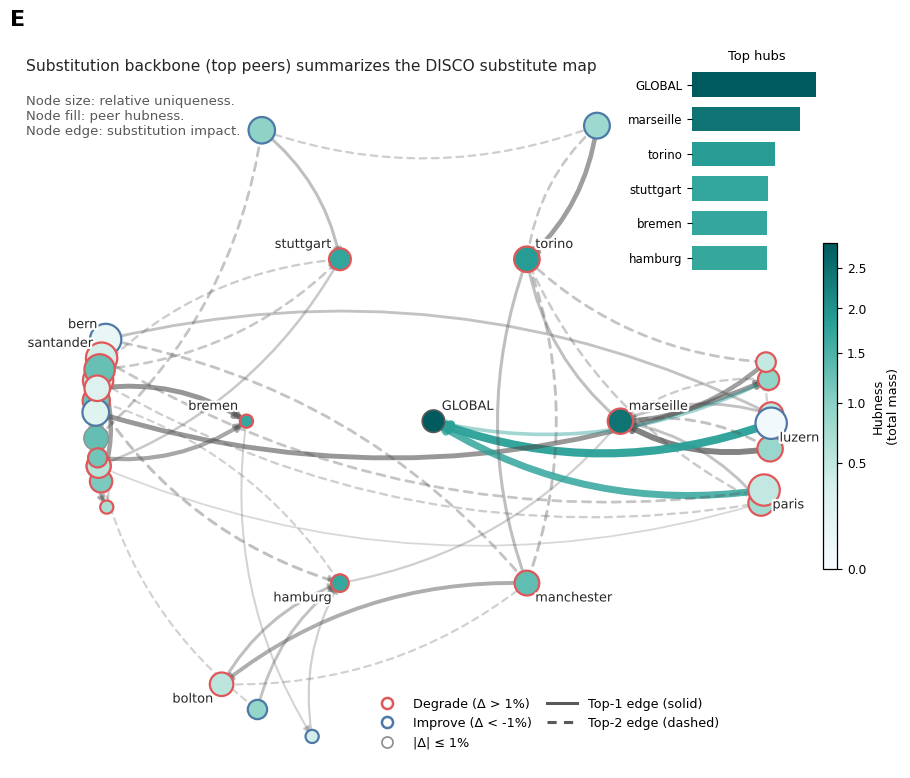

In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


# -------------------------
# Style helpers (keep consistent across Fig.5A–E)
# -------------------------
def apply_nature_style():
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10.2,
        "ytick.labelsize": 10.2,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": False,
        "legend.frameon": False,
    })


def _pick_col(df: pd.DataFrame, candidates):
    """Pick a column name from candidates using case-insensitive matching."""
    cols = list(df.columns)
    low = {c.lower(): c for c in cols}
    for c in candidates:
        if c in cols:
            return c
        if c.lower() in low:
            return low[c.lower()]
    return None


def _teal_weight_cmap():
    """A clean sequential teal colormap (Nature-friendly)."""
    return LinearSegmentedColormap.from_list(
        "teal_seq",
        ["#F7FBFF", "#D7F0EB", "#8ED3C7", "#2AA198", "#005B5E"]
    )


def annotate_offset(ax, xy, text, dx=6, dy=6, fontsize=9.4, color="0.15",
                    ha="left", va="bottom", **kwargs):
    """Screen-space annotation (stable for any data scale)."""
    return ax.annotate(
        text,
        xy=xy,
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha, va=va,
        fontsize=fontsize,
        color=color,
        **kwargs
    )


# -------------------------
# Fig.5E: Substitution backbone graph
# -------------------------
def plot_fig5E_substitution_backbone_graph(
    summary_csv: str = "../results/tables/exp14_multicity_tabular_summary.csv",
    weights_long_csv: str = "../results/tables/exp14_multicity_tabular_summary_peer_weights_long.csv",
    save_path: str = None,
    band_pct: float = 1.0,
    hub_top: int = 6,
    secondary_edge_thresh: float = 0.18,
    secondary_edge_cap: float = 0.70,
    seed: int = 7,
):
    """
    Fig.5E (recommended):
      A directed "substitution backbone" graph summarizing DISCO weights.

    Encodings:
      - Node size  ~ relative uniqueness: 1000 * PIER / flow
      - Node fill  ~ peer hubness: sum_i w_hat(i -> node)
      - Node edge  ~ substitution impact category (degrade / improve / near-zero)
      - Edges      ~ top-1 peer per target (solid), optional top-2 (dashed)
      - Edge width/alpha ~ weight magnitude

    Why this panel is useful:
      - It makes the 'near-diagonal' structure in the weight matrix obvious,
        but in a representation that is harder to misread as self-fit.
      - It highlights hub-centric replacement structure while keeping uniqueness and risk separate.
    """

    apply_nature_style()

    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Missing summary CSV: {summary_csv}")
    if not os.path.exists(weights_long_csv):
        raise FileNotFoundError(f"Missing weights CSV: {weights_long_csv}")

    summ = pd.read_csv(summary_csv)
    wlong = pd.read_csv(weights_long_csv)

    # --- summary metrics ---
    req = {"City", "MeanFlow_Test", "PIER", "Local_MAE", "Delta_Router"}
    missing = req - set(summ.columns)
    if missing:
        raise ValueError(f"Missing columns in summary: {missing}")

    for c in ["MeanFlow_Test", "PIER", "Local_MAE", "Delta_Router"]:
        summ[c] = pd.to_numeric(summ[c], errors="coerce")

    summ = summ.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["City", "MeanFlow_Test", "PIER", "Local_MAE"]
    ).copy()
    summ["City"] = summ["City"].astype(str).str.strip()

    eps = 1e-12
    summ["pier_rel"] = 1000.0 * summ["PIER"] / (summ["MeanFlow_Test"].abs() + eps)  # per-mille
    summ["impact_pct"] = 100.0 * summ["Delta_Router"] / (summ["Local_MAE"].abs() + eps)

    band = float(band_pct)
    summ["impact_cat"] = np.where(
        summ["impact_pct"] > band, "degrade",
        np.where(summ["impact_pct"] < -band, "improve", "near-zero")
    )

    EDGE_COL = {"degrade": "#E15759", "improve": "#4E79A7", "near-zero": "0.55"}

    # --- weights long -> matrix ---
    col_tgt = _pick_col(wlong, ["City", "TargetCity", "Target", "target", "target_city"])
    col_peer = _pick_col(wlong, ["Peer", "PeerCity", "peer", "peer_city", "PeerName", "peer_name"])
    col_w = _pick_col(wlong, ["Weight", "weight", "w_hat", "w", "PeerWeight", "peer_weight"])

    if col_tgt is None or col_peer is None or col_w is None:
        raise ValueError(
            "Cannot infer columns in weights_long_csv. Expected (Target, Peer, Weight). "
            f"Found: {list(wlong.columns)}"
        )

    wlong[col_tgt] = wlong[col_tgt].astype(str).str.strip()
    wlong[col_peer] = wlong[col_peer].astype(str).str.strip()
    wlong[col_w] = pd.to_numeric(wlong[col_w], errors="coerce")
    wlong = wlong.replace([np.inf, -np.inf], np.nan).dropna(subset=[col_tgt, col_peer, col_w]).copy()

    W = wlong.pivot_table(
        index=col_tgt, columns=col_peer, values=col_w, aggfunc="mean", fill_value=0.0
    )

    # Align targets to summary cities
    keep_rows = [c for c in summ["City"].tolist() if c in W.index]
    W = W.loc[keep_rows].copy()

    # Remove self-peers explicitly (avoid trivial self-substitution)
    for city in W.index:
        if city in W.columns:
            W.loc[city, city] = 0.0

    # Row-normalize
    rs = W.sum(axis=1).replace(0.0, np.nan)
    W = W.div(rs, axis=0).fillna(0.0)

    # Nodes = all targets plus peers that appear in columns (e.g., GLOBAL)
    nodes = sorted(set(W.index.tolist()) | set(W.columns.tolist()))
    summ_m = summ.set_index("City")

    # Peer hubness (incoming mass)
    hub = W.sum(axis=0)
    hub = hub.reindex(nodes).fillna(0.0)

    # --- edges: top-1 (and optional top-2) per target ---
    edges = []
    top1_peer = {}
    rng = np.random.default_rng(seed)

    for city in W.index:
        row = W.loc[city].copy()
        if city in row.index:
            row.loc[city] = 0.0
        row = row.sort_values(ascending=False)

        p1 = row.index[0]
        w1 = float(row.iloc[0])
        top1_peer[city] = p1
        if w1 > 0:
            edges.append((city, p1, w1, "primary"))

        # Optional secondary edge: show mixing when not extremely concentrated
        if len(row) >= 2:
            p2 = row.index[1]
            w2 = float(row.iloc[1])
            if (w2 >= secondary_edge_thresh) and (w1 <= secondary_edge_cap):
                edges.append((city, p2, w2, "secondary"))

    # --- layout: GLOBAL center, top hubs inner ring, others outer ring grouped by top-1 peer ---
    GLOBAL = "GLOBAL" if "GLOBAL" in nodes else None

    # Hub candidates exclude GLOBAL for the inner ring
    hub_sorted = hub.sort_values(ascending=False)
    hub_nodes = [n for n in hub_sorted.index.tolist() if n != GLOBAL and hub_sorted[n] > 0][:int(hub_top)]
    if GLOBAL is not None:
        anchor_nodes = [GLOBAL] + hub_nodes
    else:
        anchor_nodes = hub_nodes[:]

    # Assign anchor angles
    inner_angles = {}
    if GLOBAL is not None:
        inner_angles[GLOBAL] = 0.0

    if len(hub_nodes) > 0:
        for i, hname in enumerate(hub_nodes):
            inner_angles[hname] = 2.0 * np.pi * i / max(1, len(hub_nodes))

    # Positions dict
    pos = {}

    # GLOBAL at center
    if GLOBAL is not None:
        pos[GLOBAL] = (0.0, 0.0)

    # Inner ring: hubs
    r_inner = 0.62 if GLOBAL is not None else 0.72
    for hname in hub_nodes:
        ang = inner_angles[hname]
        pos[hname] = (r_inner * np.cos(ang), r_inner * np.sin(ang))

    # Outer ring: remaining nodes
    r_outer = 1.12
    outer_nodes = [n for n in nodes if n not in pos]

    # Group outer nodes by their top-1 peer anchor (if unknown, group by 'OTHER')
    groups = {}
    for n in outer_nodes:
        if n in top1_peer:
            a = top1_peer[n]
            if a not in inner_angles:
                a = "OTHER"
        else:
            a = "OTHER"
        groups.setdefault(a, []).append(n)

    # Deterministic order inside each group: by uniqueness (desc), then name
    def _pier_val(name):
        return float(summ_m.loc[name, "pier_rel"]) if name in summ_m.index else 0.0

    for a in list(groups.keys()):
        groups[a] = sorted(groups[a], key=lambda x: (-_pier_val(x), x))

    # Angle for OTHER group
    if "OTHER" in groups:
        if len(hub_nodes) > 0:
            inner_angles["OTHER"] = np.pi  # opposite side
        else:
            inner_angles["OTHER"] = 0.0

    # Place each group near its anchor angle with a small spread
    for a, items in groups.items():
        ang0 = inner_angles.get(a, 0.0)
        m = len(items)
        if m == 1:
            angs = [ang0]
        else:
            spread = min(np.deg2rad(28.0), np.deg2rad(6.0) * m)
            angs = np.linspace(ang0 - 0.5 * spread, ang0 + 0.5 * spread, m)

        for name, ang in zip(items, angs):
            # Add tiny jitter to reduce perfect overlaps
            ang = float(ang + rng.normal(0.0, np.deg2rad(1.5)))
            pos[name] = (r_outer * np.cos(ang), r_outer * np.sin(ang))

    # -------------------------
    # Draw
    # -------------------------
    fig, ax = plt.subplots(figsize=(18.6, 9.4))
    ax.set_aspect("equal")
    ax.axis("off")

    # Colors for node fill (hubness)
    cmap = _teal_weight_cmap()
    hn = hub.copy()
    # Robust normalization for hubness
    hmax = float(np.nanpercentile(hn.values, 100)) if np.isfinite(np.nanpercentile(hn.values, 100)) else float(hn.max())
    hmax = max(hmax, 1e-6)
    hnorm = mcolors.PowerNorm(gamma=0.65, vmin=0.0, vmax=hmax)

    # Node sizes from uniqueness
    pier = pd.Series({_n: _pier_val(_n) for _n in nodes})
    p_low = float(np.nanpercentile(pier.values, 10))
    p_hi = float(np.nanpercentile(pier.values, 90))
    denom = max(1e-12, p_hi - p_low)

    def size_from_pier(v):
        # Area units (scatter s): use sqrt scaling to avoid giant nodes
        x = np.clip((v - p_low) / denom, 0.0, 1.0)
        return 90.0 + 420.0 * np.sqrt(x)

    # Build per-node draw attributes
    xs, ys, ss, fcs, ecs, ews = [], [], [], [], [], []
    for n in nodes:
        x, y = pos.get(n, (0.0, 0.0))
        xs.append(x); ys.append(y)

        v = float(pier.get(n, 0.0))
        if n == GLOBAL:
            ss.append(260.0)
        else:
            ss.append(size_from_pier(v))

        # Fill by hubness
        fcs.append(cmap(hnorm(float(hn.get(n, 0.0)))))

        # Edge color by impact category (cities only)
        if n in summ_m.index:
            cat = str(summ_m.loc[n, "impact_cat"])
            ecs.append(EDGE_COL.get(cat, "0.55"))
            ews.append(1.6 if cat in {"degrade", "improve"} else 0.9)
        else:
            ecs.append("0.35")
            ews.append(1.2)

    # Draw edges first (behind nodes)
    def _edge_rad(src, dst):
        # Deterministic curvature to reduce overlaps
        k = (hash(src) ^ hash(dst)) % 7
        sgn = -1.0 if (k % 2 == 0) else 1.0
        return 0.18 * sgn

    for (src, dst, w, kind) in edges:
        if src not in pos or dst not in pos:
            continue

        # Edge style
        lw = 0.6 + 5.2 * float(w)
        alpha = 0.10 + 0.85 * float(w)
        ls = "-" if kind == "primary" else (0, (3.0, 2.4))  # dashed for secondary
        col = "#2AA198" if (dst == GLOBAL) else "0.30"

        a = FancyArrowPatch(
            posA=pos[src],
            posB=pos[dst],
            arrowstyle="-|>",
            mutation_scale=10.5,
            linewidth=lw,
            linestyle=ls,
            color=col,
            alpha=alpha,
            connectionstyle=f"arc3,rad={_edge_rad(src, dst)}",
            zorder=1
        )
        ax.add_patch(a)

    # Draw nodes
    ax.scatter(
        xs, ys, s=ss,
        c=fcs,
        edgecolors=ecs,
        linewidths=ews,
        zorder=3
    )

    # Label a small, informative subset (avoid clutter)
    label_set = set()
    # Always label GLOBAL + hubs
    if GLOBAL is not None:
        label_set.add(GLOBAL)
    label_set |= set(hub_nodes)

    # Also label top unique cities and extreme impacts
    if len(summ) > 0:
        top_unique = summ.sort_values("pier_rel", ascending=False)["City"].head(3).tolist()
        top_degrade = summ.sort_values("impact_pct", ascending=False)["City"].head(2).tolist()
        top_improve = summ.sort_values("impact_pct", ascending=True)["City"].head(2).tolist()
        for x in top_unique + top_degrade + top_improve:
            label_set.add(x)

    # Annotate labels with quadrant-aware offsets
    for n in sorted(label_set):
        if n not in pos:
            continue
        x, y = pos[n]
        dx = 6 if x >= 0 else -6
        dy = 6 if y >= 0 else -6
        ha = "left" if x >= 0 else "right"
        va = "bottom" if y >= 0 else "top"

        annotate_offset(
            ax, (x, y), n,
            dx=dx, dy=dy,
            fontsize=9.3,
            color="0.15",
            ha=ha, va=va,
            path_effects=[pe.withStroke(linewidth=3.2, foreground="white")],
            zorder=5
        )

    # Title + small explanation
    ax.text(
        0.00, 0.98,
        "Substitution backbone (top peers) summarizes the DISCO substitute map",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=11.2, color="0.15"
    )
    ax.text(
        0.00, 0.93,
        "Node size: relative uniqueness. \nNode fill: peer hubness. \nNode edge: substitution impact.",
        transform=ax.transAxes,
        ha="left", va="top",
        fontsize=9.5, color="0.35"
    )

    # Panel label
    ax.text(-0.02, 1.02, "E", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

    # Legends
    leg_handles = [
        Line2D([0], [0], marker="o", linestyle="None", markersize=8,
               markerfacecolor="white", markeredgecolor=EDGE_COL["degrade"], markeredgewidth=1.8,
               label=f"Degrade (Δ > {band:.0f}%)"),
        Line2D([0], [0], marker="o", linestyle="None", markersize=8,
               markerfacecolor="white", markeredgecolor=EDGE_COL["improve"], markeredgewidth=1.8,
               label=f"Improve (Δ < -{band:.0f}%)"),
        Line2D([0], [0], marker="o", linestyle="None", markersize=8,
               markerfacecolor="white", markeredgecolor=EDGE_COL["near-zero"], markeredgewidth=1.2,
               label=f"|Δ| ≤ {band:.0f}%"),
        Line2D([0], [0], color="0.35", lw=2.2, label="Top-1 edge (solid)"),
        Line2D([0], [0], color="0.35", lw=2.2, linestyle=(0, (3.0, 2.4)), label="Top-2 edge (dashed)"),
    ]
    ax.legend(
        handles=leg_handles,
        loc="lower left",
        bbox_to_anchor=(0.41, 0.01),
        fontsize=9.2,
        ncol=2,
        handlelength=2.4,
        columnspacing=1.2
    )

    # Hubness colorbar (compact inset)
    sm = plt.cm.ScalarMappable(norm=hnorm, cmap=cmap)
    sm.set_array([])
    cax = inset_axes(ax, width="1.8%", height="45%", loc="center right", borderpad=0.2)
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label("Hubness\n(total mass)", fontsize=9.2)
    cb.ax.tick_params(labelsize=8.8)

    # Optional inset: top hubs bar chart (quantitative)
    inset = inset_axes(ax, width="16%", height="30%", loc="upper right", borderpad=1.1)
    inset.set_title("Top hubs", fontsize=9.4, pad=2)

    hub_show = hub_sorted.head(min(6, len(hub_sorted))).copy()
    names = hub_show.index.tolist()[::-1]
    vals = hub_show.values[::-1]
    cols = [cmap(hnorm(v)) for v in vals]

    inset.barh(np.arange(len(names)), vals, color=cols, edgecolor="none", height=0.70)
    inset.set_yticks(np.arange(len(names)))
    inset.set_yticklabels(names, fontsize=8.5)
    inset.set_xticks([])
    for sp in inset.spines.values():
        sp.set_visible(False)

    # Tight limits
    ax.set_xlim(-1.35, 1.35)
    ax.set_ylim(-1.15, 1.25)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig5E_substitution_backbone_graph(
    summary_csv="../results/tables/exp14_multicity_tabular_summary.csv",
    weights_long_csv="../results/tables/exp14_multicity_tabular_summary_peer_weights_long.csv",
    save_path="../results/figures/fig5E_substitution_backbone_graph.pdf",
    band_pct=1.0,
    hub_top=6,
    secondary_edge_thresh=0.18,
    secondary_edge_cap=0.70,
    seed=7,
);


Saved: ../results/figures/fig5E_governance_curve_final.pdf


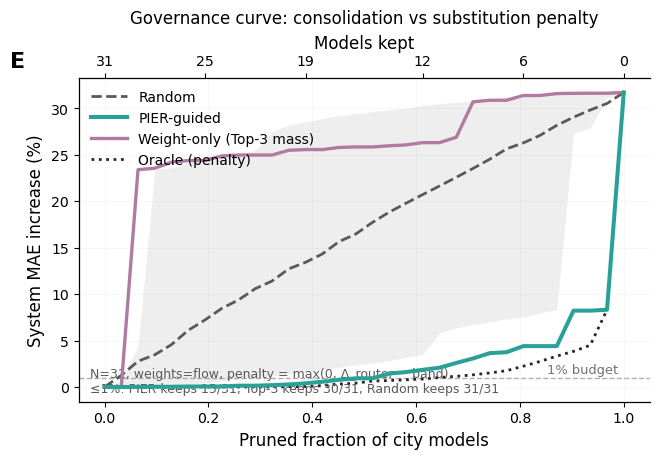

In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# -------------------------
# Style (consistent across Fig.5A–E)
# -------------------------
def apply_nature_style():
    plt.rcParams.update({
        "font.family": "DejaVu Sans",
        "font.size": 12,
        "axes.labelsize": 12,
        "axes.titlesize": 12,
        "xtick.labelsize": 10.2,
        "ytick.labelsize": 10.2,
        "axes.linewidth": 0.9,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.grid": True,
        "grid.alpha": 0.10,
        "grid.linewidth": 0.7,
        "legend.frameon": False,
    })


def _compute_curve(order, penalty, weights, local_mae):
    """
    First-order governance curve:
      cost(k) = sum_{pruned<=k} w_i * penalty_i / sum_all w_i * local_mae_i

    Returns:
      fracs: pruned fraction in [0,1]
      kept : number of models kept
      ys   : system MAE increase (%) as pruning grows
    """
    order = np.asarray(order, dtype=int)
    w = np.asarray(weights, dtype=float)
    p = np.asarray(penalty, dtype=float)
    l = np.asarray(local_mae, dtype=float)

    denom = float(np.nansum(w * l)) + 1e-12

    N = len(order)
    ys = np.zeros(N + 1, dtype=float)
    cum = 0.0
    ys[0] = 0.0
    for k in range(1, N + 1):
        i = order[k - 1]
        cum += float(w[i] * p[i])
        ys[k] = 100.0 * cum / denom

    fracs = np.linspace(0.0, 1.0, N + 1)
    kept = np.arange(N, -1, -1)
    return fracs, kept, ys


def _k_at_threshold(fracs, ys, thr):
    """Return the max prune fraction f such that y <= thr."""
    ok = np.where(ys <= thr)[0]
    if len(ok) == 0:
        return 0.0
    return float(fracs[int(ok.max())])


def plot_fig5E_governance_curve_final(
    summary_csv: str = "../results/tables/exp14_multicity_tabular_summary.csv",
    save_path: str = None,
    weight_mode: str = "flow",     # "flow" or "uniform"
    band_pct: float = 1.0,
    penalty_mode: str = "excess",  # "penalty" or "excess"
    random_trials: int = 400,
    band_q=(10, 90),
    show_oracle: bool = True,
    sweet_thr_pct: float = 1.0,    # annotate prune-able fraction under this system cost
    seed: int = 7,
):
    """
    Fig.5E (recommended):
      PIER-guided vs Top-3-mass heuristic vs Random (+ band) and an Oracle reference.

    Why Top-3 mass is a strong baseline:
      It uses only DISCO weights (mixture concentration) and ignores the geometric residual
      that defines PIER. This isolates the value of the convex-hull geometry.
    """

    apply_nature_style()
    rng = np.random.default_rng(seed)

    if not os.path.exists(summary_csv):
        raise FileNotFoundError(f"Missing summary CSV: {summary_csv}")

    df = pd.read_csv(summary_csv).copy()

    req = {"City", "PIER", "Local_MAE", "Delta_Router", "MeanFlow_Test", "TopKMass3"}
    miss = req - set(df.columns)
    if miss:
        raise ValueError(f"Missing columns in summary CSV: {miss}")

    for c in ["PIER", "Local_MAE", "Delta_Router", "MeanFlow_Test", "TopKMass3"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.replace([np.inf, -np.inf], np.nan).dropna(
        subset=["City", "PIER", "Local_MAE", "Delta_Router", "MeanFlow_Test", "TopKMass3"]
    ).copy()
    df["City"] = df["City"].astype(str).str.strip()

    N = len(df)
    if N < 5:
        raise ValueError(f"Too few cities after cleaning: N={N}")

    # Weights
    if weight_mode == "flow":
        w = df["MeanFlow_Test"].to_numpy(dtype=float)
        w = np.where(np.isfinite(w) & (w > 0), w, 1.0)
    elif weight_mode == "uniform":
        w = np.ones(N, dtype=float)
    else:
        raise ValueError(f"Unknown weight_mode: {weight_mode}")

    local = df["Local_MAE"].to_numpy(dtype=float)
    delta = df["Delta_Router"].to_numpy(dtype=float)

    # Penalty definition (governance-faithful)
    if penalty_mode == "penalty":
        penalty = np.maximum(0.0, delta)
        penalty_note = r"penalty = max(0, Δ_router)"
    elif penalty_mode == "excess":
        band_abs = (float(band_pct) / 100.0) * local
        penalty = np.maximum(0.0, delta - band_abs)
        penalty_note = r"penalty = max(0, Δ_router − band)"
    else:
        raise ValueError("penalty_mode must be 'penalty' or 'excess'.")

    # Orders
    pier = df["PIER"].to_numpy(dtype=float)
    top3 = df["TopKMass3"].to_numpy(dtype=float)

    order_pier = np.argsort(pier)              # prune low PIER first
    order_top3 = np.argsort(-top3)             # prune high top-3 mass first (most "covered")
    order_orac = np.argsort(penalty)           # oracle reference (not deployable)

    fr, kept, y_pier = _compute_curve(order_pier, penalty, w, local)
    _,  _,    y_top3 = _compute_curve(order_top3, penalty, w, local)
    _,  _,    y_orac = _compute_curve(order_orac, penalty, w, local)

    # Random band
    Yrand = np.zeros((int(random_trials), N + 1), dtype=float)
    base = np.arange(N, dtype=int)
    for t in range(int(random_trials)):
        rng.shuffle(base)
        _, _, yy = _compute_curve(base, penalty, w, local)
        Yrand[t, :] = yy

    qlo, qhi = band_q
    y_rand_mean = Yrand.mean(axis=0)
    y_rand_lo = np.percentile(Yrand, qlo, axis=0)
    y_rand_hi = np.percentile(Yrand, qhi, axis=0)

    # Threshold annotations
    thr = float(sweet_thr_pct)
    f_pier = _k_at_threshold(fr, y_pier, thr)
    f_top3 = _k_at_threshold(fr, y_top3, thr)
    f_rand = _k_at_threshold(fr, y_rand_mean, thr)

    def frac_to_kept(x):
        return int(round(N * (1.0 - x)))

    # Colors
    C_PIER = "#2AA198"   # teal
    C_TOP3 = "#B07AA1"   # muted purple
    C_RAND = "0.35"
    C_ORAC = "0.15"

    # -------------------------
    # Main plot
    # -------------------------
    fig, ax = plt.subplots(figsize=(6.8, 4.5))
    ax.set_axisbelow(True)

    ax.fill_between(fr, y_rand_lo, y_rand_hi, color="0.6", alpha=0.16, linewidth=0, zorder=1)
    ax.plot(fr, y_rand_mean, color=C_RAND, lw=2.0, ls="--", label="Random", zorder=2)

    ax.plot(fr, y_pier, color=C_PIER, lw=2.9, label="PIER-guided", zorder=5)
    ax.plot(fr, y_top3, color=C_TOP3, lw=2.4, label="Weight-only (Top-3 mass)", zorder=4)

    if show_oracle:
        ax.plot(fr, y_orac, color=C_ORAC, lw=2.0, ls=":", label="Oracle (penalty)", zorder=3)

    ax.set_xlabel("Pruned fraction of city models")
    ax.set_ylabel("System MAE increase (%)")
    ax.set_title("Governance curve: consolidation vs substitution penalty", pad=8)

    # Secondary x-axis: models kept
    def kept_to_frac(k):
        return 1.0 - (k / max(1, N))

    sec = ax.secondary_xaxis("top", functions=(lambda x: N * (1.0 - x), kept_to_frac))
    sec.set_xlabel("Models kept")
    ticks_kept = sorted(set([N, int(round(0.8*N)), int(round(0.6*N)), int(round(0.4*N)), int(round(0.2*N)), 0]))
    sec.set_xticks(ticks_kept)

    # Annotate the "sweet spot" at threshold thr
    ax.axhline(thr, color="0.65", lw=1.0, ls="--", alpha=0.9, zorder=0)
    ax.text(0.99, thr + 0.15, f"{thr:.0f}% budget", color="0.45", fontsize=9.4,
            ha="right", va="bottom")

    # Small compact text block (no clutter)
    ax.text(
        0.02, 0.02,
        f"N={N}, weights={weight_mode}, {penalty_note}\n"
        f"≤{thr:.0f}%: PIER keeps {frac_to_kept(f_pier)}/{N}, Top-3 keeps {frac_to_kept(f_top3)}/{N}, Random keeps {frac_to_kept(f_rand)}/{N}",
        transform=ax.transAxes,
        fontsize=9.0,
        color="0.35",
        ha="left", va="bottom"
    )

    ax.legend(loc="upper left", fontsize=10.0, handlelength=2.6)

    # Panel label
    ax.text(-0.12, 1.02, "E", transform=ax.transAxes, fontsize=16, fontweight="bold", va="bottom")

    # # -------------------------
    # # Inset zoom: focus on the decision-relevant low-cost regime
    # # -------------------------
    # axins = ax.inset_axes([0.58, 0.18, 0.38, 0.34])  # [x0,y0,w,h] in axes fraction
    # axins.set_axisbelow(True)
    # axins.grid(True, linewidth=0.6, alpha=0.10)

    # axins.fill_between(fr, y_rand_lo, y_rand_hi, color="0.6", alpha=0.16, linewidth=0)
    # axins.plot(fr, y_rand_mean, color=C_RAND, lw=1.4, ls="--")
    # axins.plot(fr, y_pier, color=C_PIER, lw=2.0)
    # axins.plot(fr, y_top3, color=C_TOP3, lw=1.8)
    # if show_oracle:
    #     axins.plot(fr, y_orac, color=C_ORAC, lw=1.4, ls=":")

    # # Zoom limits (auto based on threshold)
    # axins.set_xlim(0.0, 0.95)
    # axins.set_ylim(0.0, max(3.0, 1.8 * thr))
    # axins.axhline(thr, color="0.65", lw=0.9, ls="--", alpha=0.9)
    # axins.set_xticks([0.0, 0.4, 0.8])
    # axins.set_yticks([0.0, thr, axins.get_ylim()[1]])
    # axins.tick_params(labelsize=8.8)

    # # Connect inset to main panel
    # ax.indicate_inset_zoom(axins, edgecolor="0.35", linewidth=1.0, alpha=0.9)

    fig.subplots_adjust(left=0.14, right=0.98, bottom=0.14, top=0.86)

    if save_path is not None:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        fig.savefig(save_path, dpi=300)
        print(f"Saved: {save_path}")

    plt.show()
    return fig


# Example usage:
plot_fig5E_governance_curve_final(
    summary_csv="../results/tables/exp14_multicity_tabular_summary.csv",
    save_path="../results/figures/fig5E_governance_curve_final.pdf",
    weight_mode="flow",       # also try "uniform" for robustness
    band_pct=1.0,
    penalty_mode="excess",    # recommended for governance plots
    random_trials=400,
    band_q=(10, 90),
    show_oracle=True,
    sweet_thr_pct=1.0,
    seed=7
);
